In [1]:
import pandas as pd
from pandas.testing import assert_series_equal
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import FacetGrid
from matplotlib.figure import Figure
import sys, os
from plot import vbar, hbar, adjust_figure_for_h_stack, adjust_figure_for_h_grouped, adjust_figure_for_v_grouped, palette_3, palette_4


In [2]:
questions: pd.Series = pd.read_csv('./config/questions.csv', index_col=0).squeeze()

# Setup choices_df
# choices_df contains multiple candidates of choice indexed by column name
choices_df = pd.read_csv('./config/choices.csv')
col_names = questions.index.to_series()

assert_series_equal(choices_df['設問文章'], questions[questions != "タイムスタンプ"], check_names=False, check_index=False)
choices_df.index = col_names.drop(index=questions[questions == "タイムスタンプ"].index).values
choices_df['選択肢'] = choices_df['選択肢'].str.split(',')
choices_df['選択肢'].where(choices_df['選択肢'].notna(), None, inplace=True)

# NOTE: list() will be loaded as np.array()
df = pd.read_feather('out/after_coded.feather')
df.set_index('回答番号', inplace=True)
for col in choices_df[choices_df['複数回答'] == 1].index:
    df[col] = df[col].map(lambda x: x.tolist())

label_q_ids = ['Y', 'AN', 'AS']
label_map = {
    'アセクシュアル': 'アセク',
    'アロマンティック': 'アロマ',
    'セクシュアル【性的に惹(ひ)かれる】': 'セク',
    'ロマンティック【恋愛的に惹(ひ)かれる】': 'ロマ',
    'デミセクシュアル': 'デミセク',
    'デミロマンティック': 'デミロマ',
    'グレイアセクシュアル/グレイセクシュアル': 'グレイセク',
    'グレイアロマンティック/グレイロマンティック': 'グレイロマ',
    'リスセクシュアル': 'リスセク',
    'リスロマンティック': 'リスロマ',
    'クエスチョニング': 'Q',
}

df[label_q_ids] = df[label_q_ids].replace(label_map)

exploded_choices_df: pd.Series = choices_df.loc[label_q_ids, '選択肢'].explode()
sorted_choices_df = exploded_choices_df.replace(label_map).sort_values(key=lambda series: series.map({ 'アロマ': 1, 'アセク':1 }))
updated_exploded_choices_df = sorted_choices_df.groupby(level=0).agg(list)
choices_df.update(updated_exploded_choices_df)

location_source = {
    '北海道': ['北海道'],
    '東北': ['青森県', '岩手県', '宮城県', '秋田県', '山形県', '福島県'],
    '南関東\n(東京以外)': ['埼玉県', '千葉県', '神奈川県'],
    '東京都': ['東京都'],
    '北関東\n甲信': ['茨城県', '栃木県', '群馬県', '山梨県', '長野県'],
    '北陸': ['新潟県', '富山県', '石川県', '福井県'],
    '東海': ['岐阜県', '静岡県', '愛知県', '三重県'],
    '近畿': ['滋賀県', '京都府', '大阪府', '兵庫県', '奈良県', '和歌山県'],
    '中国': ['鳥取県', '島根県', '岡山県', '広島県', '山口県'],
    '四国': ['徳島県', '香川県', '愛媛県', '高知県'],
    '九州\n沖縄': ['福岡県', '佐賀県', '長崎県', '熊本県', '大分県', '宮崎県', '鹿児島県', '沖縄県'],
}

location_map = {}

for cat, values in location_source.items():
    for value in values:
        location_map[value] = cat


ages_bin_labels = ['20歳未満', '20-24歳', '25-29歳', '30-34歳', '35-39歳', '40-44歳', '45歳以上']
def cut_ages_bin(ages):
    return pd.cut(ages, [-1, 20, 25, 30, 35, 40, 45, 10000], labels=ages_bin_labels, right=False)


In [3]:
from typing import List

def plot_bar(column: str, direction: str, title: str, description: str = '', other_groups: List[str] = [], sort: bool = False):
    values = df[column].dropna()
    if choices_df.loc[column, '複数回答'] == 1:
        values = values[df[column].astype(bool)]  # drop empty list
    n = len(values)

    data = values.explode().value_counts(sort=sort) * 100 / n

    choices = data.index if sort else pd.Index(choices_df.loc[column, '選択肢']).union(data.index, sort=False)
    index_order = choices.drop(other_groups, errors='ignore').append(pd.Index(other_groups))

    data = data.reindex(index_order)

    if direction == 'v':
        figure = vbar(data, n, title, description)
    elif direction == 'h':
        figure = hbar(data, n, title, description)
    else:
        raise ValueError(f'Unknown direction: {direction}')

    save_figure(figure, title)

def plot_age_bin_bar(column: str, direction: str , title: str, description: str = ''):
    ages = df[column].dropna()
    n = len(ages)

    ages_bin = cut_ages_bin(ages)

    ages_bin_count = ages_bin.value_counts(sort=False) * 100 / n

    if direction == 'v':
        figure = vbar(ages_bin_count, n, title, description)
    elif direction == 'h':
        figure = hbar(ages_bin_count, n, title, description)
    else:
        raise ValueError(f'Unknown direction: {direction}')

    save_figure(figure, title)

def plot_stacked_hbar(column: str, title: str, description: str = '', other_groups: List[str] = []):
    data = (df[column]
            .value_counts(normalize=True)
            .mul(100)
            .rename_axis(column)
            .rename('percent')
            .to_frame())
    n = df[column].count()

    choices = pd.Index(choices_df.loc[column, '選択肢']).union(data.index, sort=False)
    index_order = choices.drop(other_groups, errors='ignore').append(pd.Index(other_groups)).rename(column)

    data = data.reindex(index_order)

    grid: FacetGrid = sns.displot(
        data=data, y=[''] * len(data), hue=column, weights='percent',
        multiple='stack', shrink=0.8, discrete=True,
        alpha=1,
        hue_order=choices_df.loc[column, '選択肢'],
        aspect=16/9,
        # legend=False,
    )
    figure: Figure = grid.figure
    adjust_figure_for_h_stack(grid.figure, n, title, description)
    figure.axes[0].margins(y=0.7)

    save_figure(figure, title)

def plot_stacked_hbar_grouped(column: str, group_by: str, title: str, description: str = '', other_groups: List[str] = []):
    table = pd.crosstab(df[column], df[group_by], normalize='columns')

    choices = pd.Index(choices_df.loc[group_by, '選択肢']).union(pd.Index(table.columns), sort=False)
    col_order = choices.drop(other_groups, errors='ignore').append(pd.Index(other_groups))

    # TODO: filter can drop nonexistent columns
    data = table.filter(col_order).unstack(fill_value=0).mul(100).rename('percent').reset_index()
    label_map = {}
    for name, count in df[group_by].dropna().value_counts().items():
        label_map[name] = f'{name}\nn={count}'
    data[group_by] = data[group_by].map(label_map)

    grid: FacetGrid = sns.displot(
        data=data, y=group_by, hue=column, weights='percent',
        multiple='stack', shrink=0.8, discrete=True,
        alpha=1,
        hue_order=pd.Index(choices_df.loc[column, '選択肢']).union(pd.Index(table.index), sort=False),
        aspect=16/9,
    )
    figure: Figure = grid.figure
    adjust_figure_for_h_stack(grid.figure, None, title, description)

    save_figure(figure, title)

def plot_bar_grouped(column: str, group_by: str, direction: str, title: str, description: str = '', other_groups: List[str] = [], filter_answers: List[str] | None = None, palette = None):
    filtered_df = df.explode(column).dropna(subset=[column])
    if filter_answers:
        filtered_df = filtered_df[filtered_df[column].isin(filter_answers)]
    table = pd.crosstab(filtered_df[column], filtered_df[group_by], normalize='columns')

    choices = pd.Index(choices_df.loc[group_by, '選択肢']).union(pd.Index(table.columns), sort=False)
    col_order = choices.drop(other_groups, errors='ignore').append(pd.Index(other_groups))

    # TODO: filter can drop nonexistent columns
    data = table.filter(col_order).unstack(fill_value=0).mul(100).rename('percent').reset_index()

    if direction == 'v':
        grid: FacetGrid = sns.catplot(data=data, y='percent', x=group_by, hue=column, hue_order=filter_answers, kind='bar', orient='v', width=0.5, aspect=16/9, palette=palette)
        figure: Figure = grid.figure
        adjust_figure_for_v_grouped(grid.figure, None, title, description)
    elif direction == 'h':
        grid: FacetGrid = sns.catplot(data=data, x='percent', y=group_by, hue=column, hue_order=filter_answers, kind='bar', orient='h', height=5, aspect=16/9, palette=palette)
        figure: Figure = grid.figure
        adjust_figure_for_h_grouped(grid.figure, None, title, description)
    else:
        raise ValueError(f'Unknown direction: {direction}')

    save_figure(figure, title)

def plot_bar_with_comparison(column: str, filepath: str, index_col: str, direction: str, title: str, description: str = '', other_groups: List[str] = [], sort: bool = False):
    values = df[column].dropna()
    if choices_df.loc[column, '複数回答'] == 1:
        # Because of data2.sum()
        raise ValueError('Multiple choice column is unsupported.')
    n = len(values)

    data1 = values.explode().value_counts(sort=sort) * 100 / n

    choices = data1.index if sort else pd.Index(choices_df.loc[column, '選択肢']).union(data1.index, sort=False)
    index_order = choices.drop(other_groups, errors='ignore').append(pd.Index(other_groups))

    data1 = data1.reindex(index_order)
    data1.rename(f'Aro/Ace調査2022 (n={n})', inplace=True)

    data2 = pd.read_csv(filepath, index_col=index_col).squeeze()
    n2 = data2.sum()
    data2 = data2.groupby(level=0).sum() * 100 / n2
    data2.rename(f'Aro/Ace調査2020 (n={n2})', inplace=True)

    data = data1.to_frame().join(data2.reindex(data1.index), how='outer')
    table = data.unstack().reset_index()
    table.columns = ['ソース', index_col, 'percent']

    if direction == 'v':
        grid: FacetGrid = sns.catplot(data=table, y='percent', x=index_col, hue='ソース', kind='bar', orient='v', width=0.5, aspect=16/9, palette=palette_3[0:2])
        figure: Figure = grid.figure
        adjust_figure_for_v_grouped(grid.figure, None, title, description, bar_label=False)
    elif direction == 'h':
        grid: FacetGrid = sns.catplot(data=table, x='percent', y=index_col, hue='ソース', kind='bar', orient='h', height=5, aspect=16/9, palette=palette_3[0:2])
        figure: Figure = grid.figure
        adjust_figure_for_h_grouped(grid.figure, None, title, description, bar_label=False)
    else:
        raise ValueError(f'Unknown direction: {direction}')
    render_bar_labels_for_comparison(grid.figure)

    save_figure(figure, title)

def plot_stacked_hbar_with_comparison(column: str, filepath: str, index_col: str, direction: str, title: str, description: str = '', other_groups: List[str] = [], sort: bool = False, palette=None):
    values = df[column].dropna()
    if choices_df.loc[column, '複数回答'] == 1:
        # Because of data2.sum()
        raise ValueError('Multiple choice column is unsupported.')
    n = len(values)

    data1 = values.explode().value_counts(sort=sort) * 100 / n

    choices = data1.index if sort else pd.Index(choices_df.loc[column, '選択肢']).union(data1.index, sort=False)
    index_order = choices.drop(other_groups, errors='ignore').append(pd.Index(other_groups))

    data1 = data1.reindex(index_order)
    data1.rename(f'Aro/Ace調査2022\n\nn={n}', inplace=True)

    data2 = pd.read_csv(filepath, index_col=index_col).squeeze()
    n2 = data2.sum()
    data2 = data2.groupby(level=0).sum() * 100 / n2
    data2.rename(f'Aro/Ace調査2020\n\nn={n2}', inplace=True)

    data = data1.to_frame().join(data2.reindex(data1.index), how='outer')

    table  = data.unstack().reset_index()
    table.columns = ['ソース', index_col, 'percent']

    grid: FacetGrid = sns.displot(
        data=table, y='ソース', hue=index_col, weights='percent',
        multiple='stack', shrink=0.8, discrete=True,
        alpha=1,
        hue_order=pd.Index(choices_df.loc[column, '選択肢']).union(data.index, sort=False),
        aspect=16/9,
        palette=palette,
    )
    figure: Figure = grid.figure
    adjust_figure_for_h_stack(grid.figure, None, title, palette=palette)

    save_figure(figure, title)

figure_num = 1

def save_figure(figure: Figure, title: str):
    plt.show()
    global figure_num
    if figure_num == 1:
        os.makedirs('out/images', 0o755, exist_ok=True)

    figure.savefig(
        f"out/images/figure-{str(figure_num).zfill(3)}-{title.replace('/', '_')}.png", format="png", dpi=144)
    figure_num += 1


def reset_figure_num():
    global figure_num
    figure_num = 1


def render_bar_labels_for_comparison(figure: Figure):
    ax = figure.axes[0]
    for i, container in enumerate(ax.containers):
        texts = ax.bar_label(container, fmt='%.1f%%', padding=4, fontsize=9)
        for text in texts:
            if i == 0:
                text.set_horizontalalignment('right')
                text.set_x(text.get_position()[0] + 5)
            else:
                text.set_horizontalalignment('left')
                text.set_x(text.get_position()[0] - 5)


In [4]:
def render_sex_plot():
    column = 'N'
    title = '男女比'

    rows = df[df['M'] == '思う'][column]
    values = rows.dropna()
    n1 = len(values)
    data1 = values.value_counts(sort=False) * 100 / n1
    index_order = pd.Index(choices_df.loc[column, '選択肢']).union(data1.index, sort=False)
    data1 = data1.reindex(index_order).rename(f'Aro/Ace調査2022\n「一致」している人\n\nn={n1}')

    data2: pd.Series = pd.read_csv('./config/reference_data/国勢調査令和2年 - 男女別人口－全国，都道府県，市区町村（2000年（平成12年）市区町村含む） - 男女.csv',
                                index_col='男女',
                                encoding='CP932',
                                usecols=['男女', 'value'],
                                na_values=['']).squeeze()
    n2 = data2.sum()
    data2.index = pd.Series(data2.index).replace({ '男': '男性', '女': '女性' })
    data2 = data2.groupby(level=0).sum() * 100 / n2
    data2.rename(f'令和2年国勢調査 (2020)\n\nN={n2}', inplace=True)

    data = data1.to_frame().join(data2.reindex(data1.index), how='outer')

    table  = data.unstack().reset_index()
    table.columns = ['ソース', '出生時の性別', 'percent']

    grid: FacetGrid = sns.displot(
        data=table, y='ソース', hue='出生時の性別', weights='percent',
        multiple='stack', shrink=0.8, discrete=True,
        alpha=1,
        hue_order=pd.Index(choices_df.loc[column, '選択肢']).union(data.index, sort=False),
        aspect=16/9,
        palette=palette_3[0:2],
    )
    figure: Figure = grid.figure
    adjust_figure_for_h_stack(grid.figure, None, title, palette=palette_3)

    save_figure(figure, title)


    title2 = '男女比 (前回調査との比較)'

    data3 = pd.read_csv('./data/sex_2020.csv', index_col='性別').squeeze()
    n3 = data3.sum()
    data3 = data3.groupby(level=0).sum() * 100 / n3
    data3.rename(f'Aro/Ace調査2020\n「一致」している人\n\nn={n3}', inplace=True)

    data = data1.to_frame().join(data3.reindex(data1.index), how='outer')

    table  = data.unstack().reset_index()
    table.columns = ['ソース', '出生時の性別', 'percent']

    grid: FacetGrid = sns.displot(
        data=table, y='ソース', hue='出生時の性別', weights='percent',
        multiple='stack', shrink=0.8, discrete=True,
        alpha=1,
        hue_order=pd.Index(choices_df.loc[column, '選択肢']).union(data.index, sort=False),
        aspect=16/9,
        palette=palette_3[0:2],
    )
    figure: Figure = grid.figure
    adjust_figure_for_h_stack(grid.figure, None, title2, palette=palette_3)

    save_figure(figure, title2)


# render_sex_plot()


In [5]:
def render_residence_plot():
    column = 'E'
    title = '居住地'

    rows = df[column].replace(location_map)
    values = rows.dropna()
    n1 = len(values)
    data1 = values.value_counts(sort=False) * 100 / n1
    index_order = pd.Index(location_source.keys()).union(data1.index, sort=False)
    data1 = data1.reindex(index_order).rename(f'Aro/Ace調査2022 (n={n1})')

    data2: pd.Series = pd.read_csv('./config/reference_data/国勢調査令和2年 - 男女別人口－全国，都道府県，市区町村（2000年（平成12年）市区町村含む） - 都道府県.csv',
                        index_col='全国，都道府県，市区町村（2000年市区町村含む）',
                        encoding='CP932',
                        usecols=['全国，都道府県，市区町村（2000年市区町村含む）', 'value'],
                        na_values=['']).squeeze()
    n2 = data2.sum()
    data2.index = pd.Series(data2.index).replace(location_map)
    data2 = data2.groupby(level=0).sum() * 100 / n2
    data2.rename(f'令和2年国勢調査 (2020) (N={n2})', inplace=True)


    data = data1.to_frame().join(data2.reindex(data1.index), how='outer').unstack().reset_index()
    data.columns = ['ソース', '地方', 'percent']

    grid: FacetGrid = sns.catplot(data=data, kind='bar', y='percent', x='地方', hue='ソース', orient='v', aspect=16/9, width=0.5, palette=palette_3[0:2])
    figure: Figure = grid.figure
    adjust_figure_for_v_grouped(grid.figure, None, title, bar_label=False)
    render_bar_labels_for_comparison(grid.figure)

    save_figure(figure, title)


    title2 = '居住地 (前回調査との比較)'

    data3: pd.Series = pd.read_csv('./data/residence_2020.csv', index_col='都道府県').squeeze()
    n3 = data3.sum()
    data3.index = pd.Series(data3.index).replace(location_map)
    data3 = data3.groupby(level=0).sum() * 100 / n3
    data3.rename(f'Aro/Ace調査2020 (n={n3})', inplace=True)

    data_prev_year = data1.to_frame().join(data3.reindex(data1.index), how='outer').unstack().reset_index()
    data_prev_year.columns = ['ソース', '地方', 'percent']

    grid: FacetGrid = sns.catplot(data=data_prev_year, kind='bar', y='percent', x='地方', hue='ソース', orient='v', aspect=16/9, width=0.5, palette=palette_3[0:2])
    figure: Figure = grid.figure
    adjust_figure_for_v_grouped(grid.figure, None, title2, bar_label=False)
    render_bar_labels_for_comparison(grid.figure)

    save_figure(figure, title2)

# render_residence_plot()


In [6]:
def render_age_plot():
    column = 'D'
    title1 = '年齢'

    values = cut_ages_bin(df[column].dropna())

    n1 = len(values)
    data1 = values.value_counts(sort=False) * 100 / n1
    index_order = pd.Index(ages_bin_labels).union(data1.index, sort=False)
    data1 = data1.reindex(index_order).rename(f'Aro/Ace調査2022 (n={n1})')

    data2: pd.Series = pd.read_csv('./config/reference_data/国勢調査令和2年 - 男女，年齢（各歳），国籍総数か日本人別人口－全国，都道府県，21大都市，特別区，人口50万以上の市 - 年齢.csv',
                        index_col='年齢',
                        encoding='CP932',
                        usecols=['年齢', 'value'],
                        na_values=['']).squeeze()
    n2 = data2.sum()

    data2.index = cut_ages_bin(data2.index.map(lambda s: s.replace('以上', '').replace('歳', '')).astype(int))
    data2 = data2.groupby(level=0).sum() * 100 / n2
    data2.rename(f'令和2年国勢調査 (2020) (N={n2})', inplace=True)

    data = data1.to_frame().join(data2.reindex(data1.index), how='outer').unstack().reset_index()
    data.columns = ['ソース', '年齢区分', 'percent']

    grid: FacetGrid = sns.catplot(data=data, kind='bar', y='percent', x='年齢区分', hue='ソース', orient='v', aspect=16/9, width=0.5, palette=palette_3[0:2])
    figure: Figure = grid.figure

    adjust_figure_for_v_grouped(grid.figure, None, title1, bar_label=False)
    render_bar_labels_for_comparison(grid.figure)

    save_figure(figure, title1)


    title2 = '年齢 (前回調査との比較)'

    data3: pd.Series = pd.read_csv('./data/ages_2020.csv', index_col='年齢').squeeze()
    n3 = data3.sum()
    data3.rename(f'Aro/Ace調査2020 (n={n3})', inplace=True)
    data3.index = cut_ages_bin(data3.index)
    data3 = data3.groupby(level=0).sum() * 100 / n3

    data_prev_year = data1.to_frame().join(data3.reindex(data1.index), how='outer').unstack().reset_index()
    data_prev_year.columns = ['ソース', '年齢区分', 'percent']

    grid: FacetGrid = sns.catplot(data=data_prev_year, kind='bar', y='percent', x='年齢区分', hue='ソース', orient='v', aspect=16/9, width=0.5, palette=palette_3[0:2])
    figure: Figure = grid.figure
    adjust_figure_for_v_grouped(grid.figure, None, title2, bar_label=False)
    render_bar_labels_for_comparison(grid.figure)

    save_figure(figure, title2)

# render_age_plot()


In [7]:
# 自分に"性欲"があると思うか×性的指向 (回答数が少ない項目のラベルが消えている)

def render_arousal_table():
    column = 'AF'
    group_by = 'AN'

    table = pd.crosstab(df[column], df[group_by], normalize='columns')
    row_order=pd.Index(choices_df.loc[column, '選択肢']).union(pd.Index(table.index), sort=False)
    table = table.reindex(row_order)

    col_order = pd.Index(choices_df.loc[group_by, '選択肢']).union(pd.Index(table.columns), sort=False)

    # TODO: filter can drop nonexistent columns
    data = table.filter(col_order).unstack(fill_value=0).mul(100).rename('percent').reset_index()
    data['percent'] = data['percent'].round(1)
    display(data)

render_arousal_table()


,AN,level_1,percent
0,アセク,思う,40.4
1,アセク,やや思う,29.2
2,アセク,どちらでもない,5.9
3,アセク,あまり思わない,15.4
4,アセク,思わない,9.0
5,セク,思う,89.5
6,セク,やや思う,8.7
7,セク,どちらでもない,0.6
8,セク,あまり思わない,0.6
9,セク,思わない,0.6


In [8]:
# 主な恋愛的指向×性的指向アイデンティティの組み合わせ

table_2020: pd.Series = pd.read_csv('./data/orientation_pairs_2020.csv', index_col=['恋愛指向','性的指向']).squeeze().rename('Aro/Ace調査2020')
rows = df[['Y', 'AN']].dropna()
rows.columns = ['恋愛指向','性的指向']
table_2022 = rows.value_counts(normalize=True).mul(100).round(1).rename('Aro/Ace調査2022')
print(f'Aro/Ace調査2022 (n={rows.index.size})') # num of rows where both columns are filled

joined_df = table_2022.to_frame().join(table_2020, how='right')
joined_df.index = joined_df.index.map(lambda index: f'{index[0]}×{index[1]}')
joined_df = joined_df.applymap(lambda x: f'{x}%')
joined_df.to_csv('out/主な恋愛的指向×性的指向アイデンティティの組み合わせ.csv')
joined_df


Aro/Ace調査2022 (n=2293)


,Aro/Ace調査2022,Aro/Ace調査2020
アロマ×アセク,33.6%,37.4%
ロマ×アセク,9.0%,10.4%
アロマ×セク,4.2%,5.5%
デミロマ×デミセク,3.7%,4.7%
Q×アセク,3.9%,4.4%
デミロマ×アセク,3.8%,3.5%
グレイロマ×アセク,4.1%,3.4%
リスロマ×アセク,3.9%,2.8%
グレイロマ×グレイセク,2.5%,2.8%
リスロマ×リスセク,1.8%,1.4%


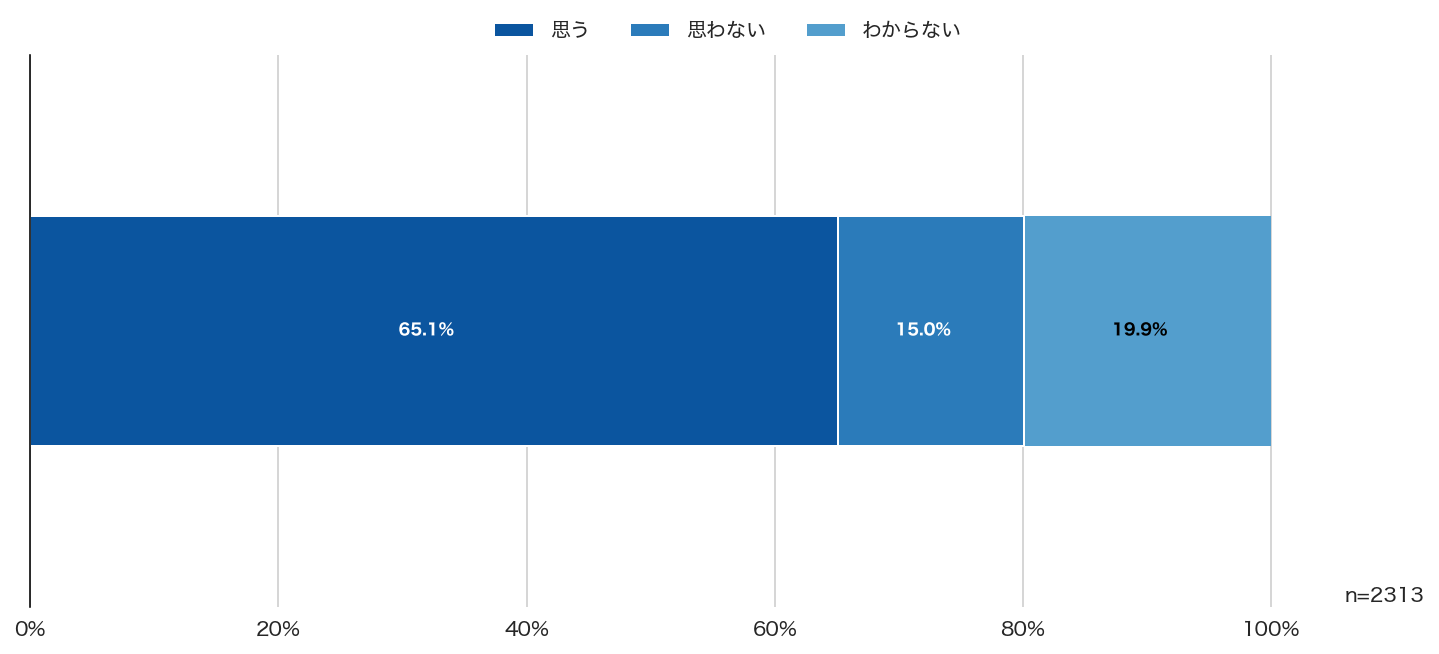

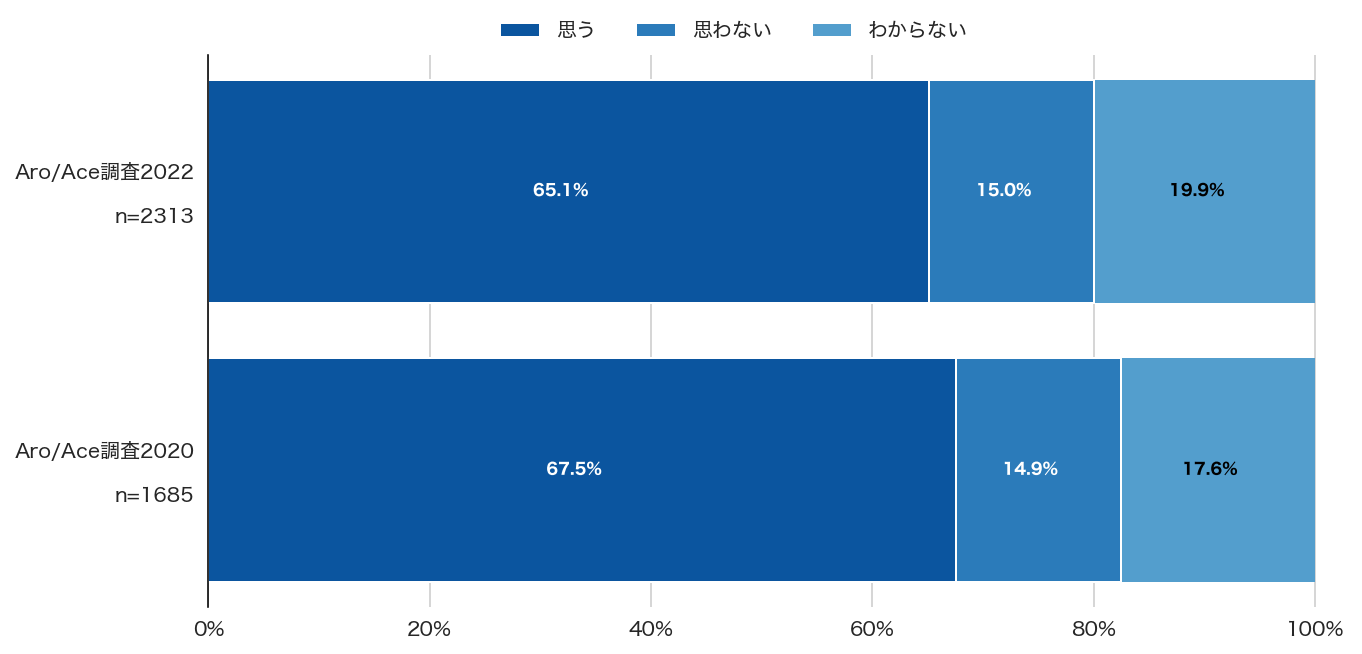

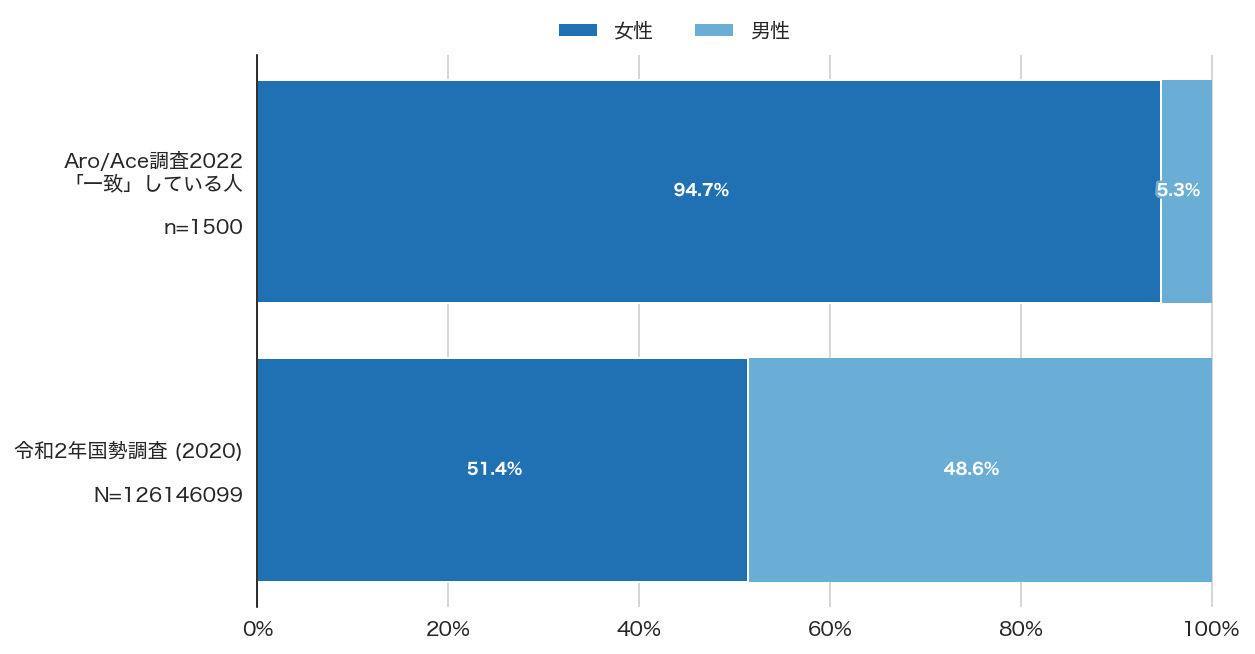

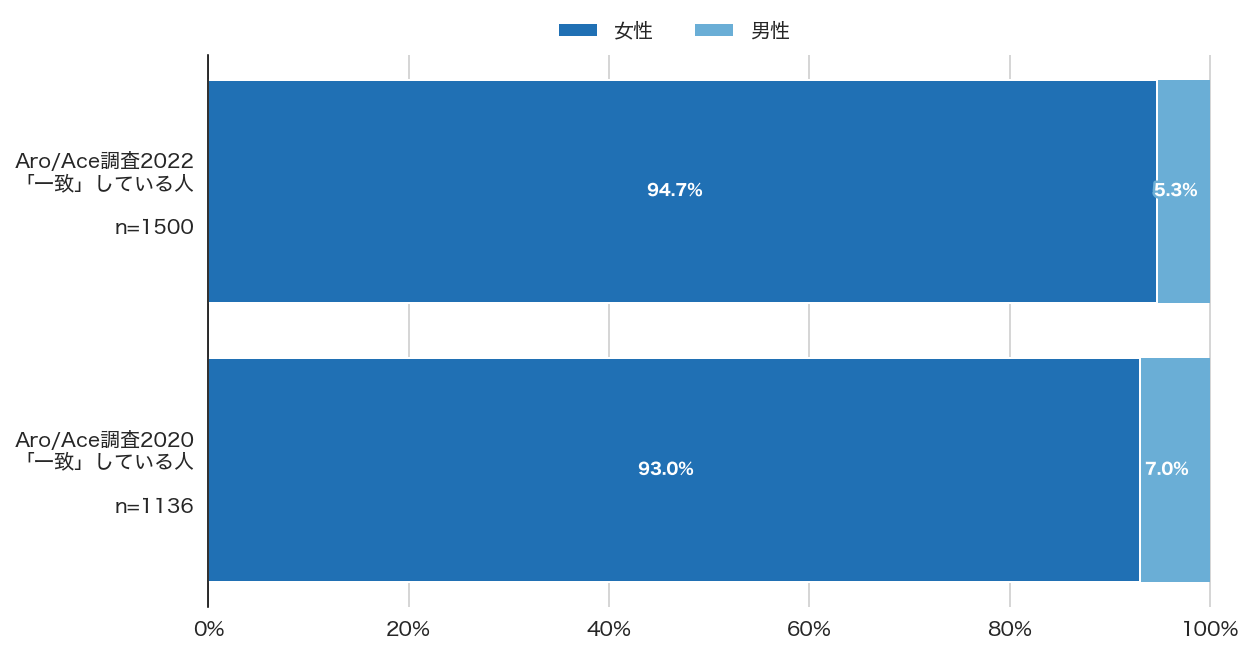

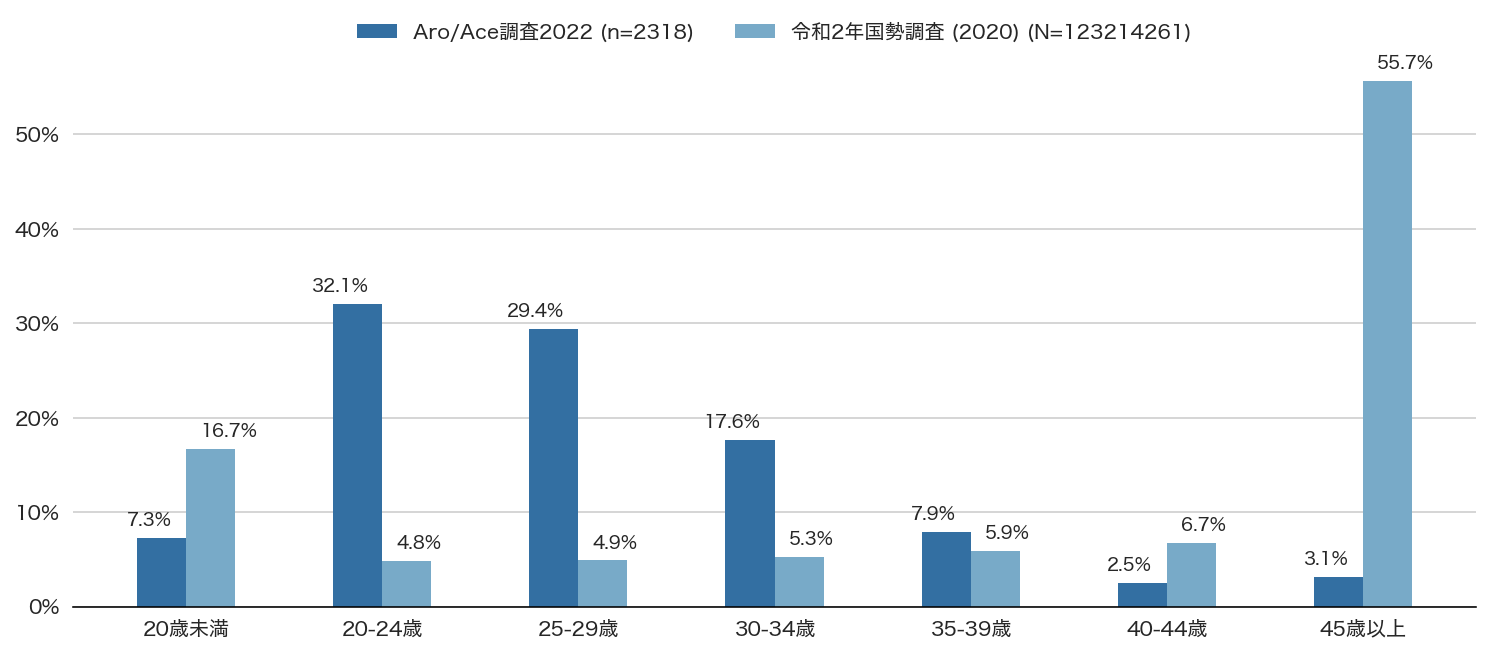

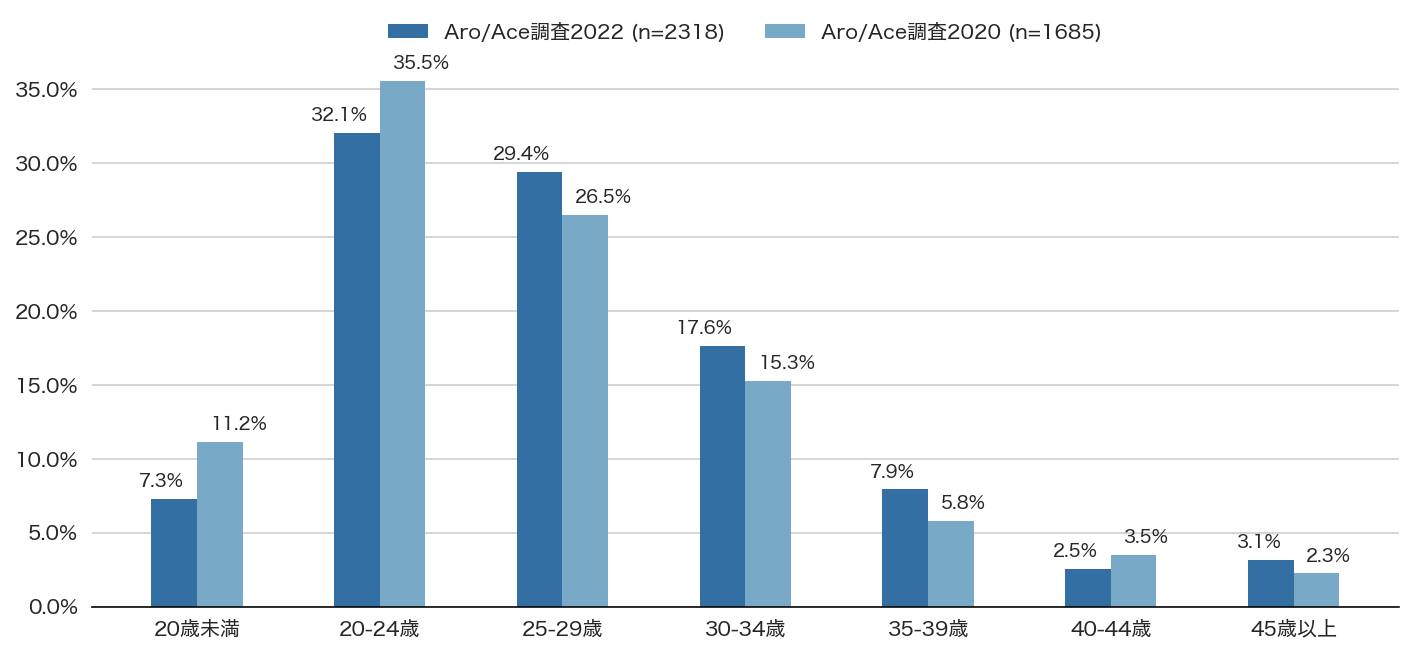

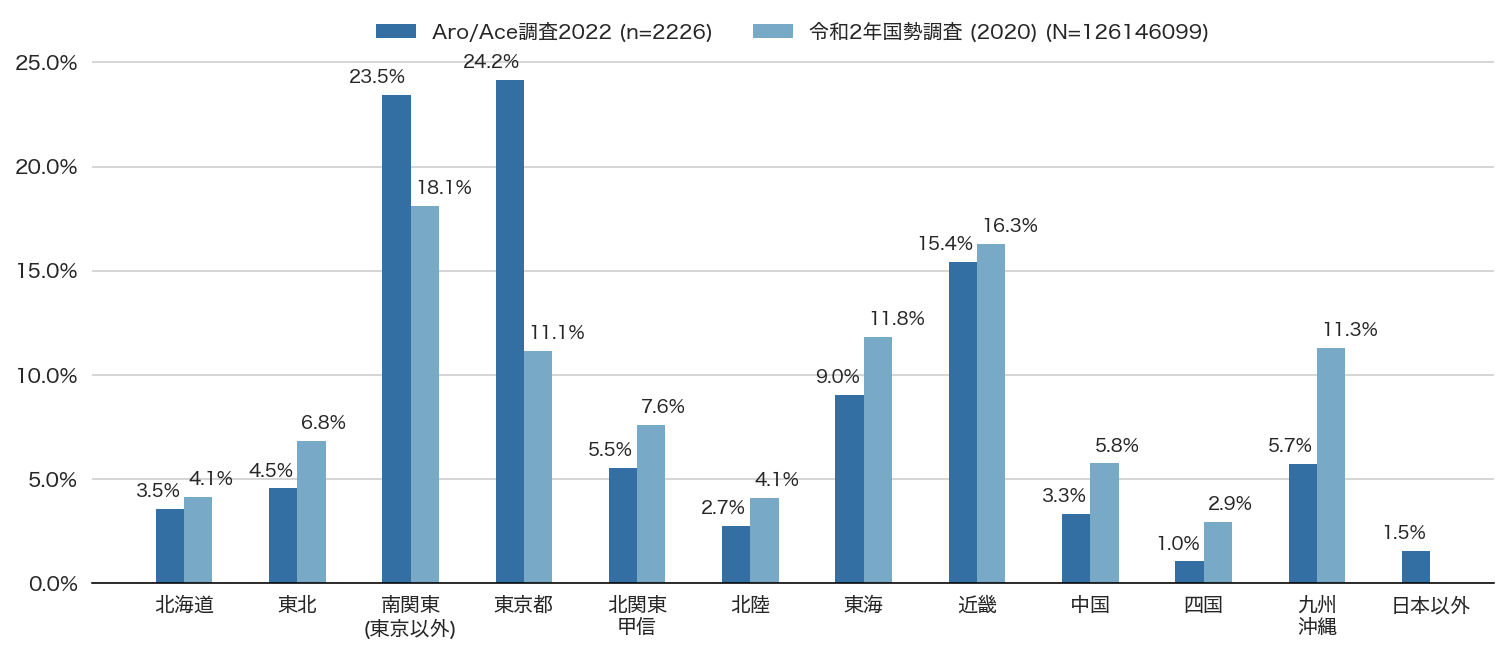

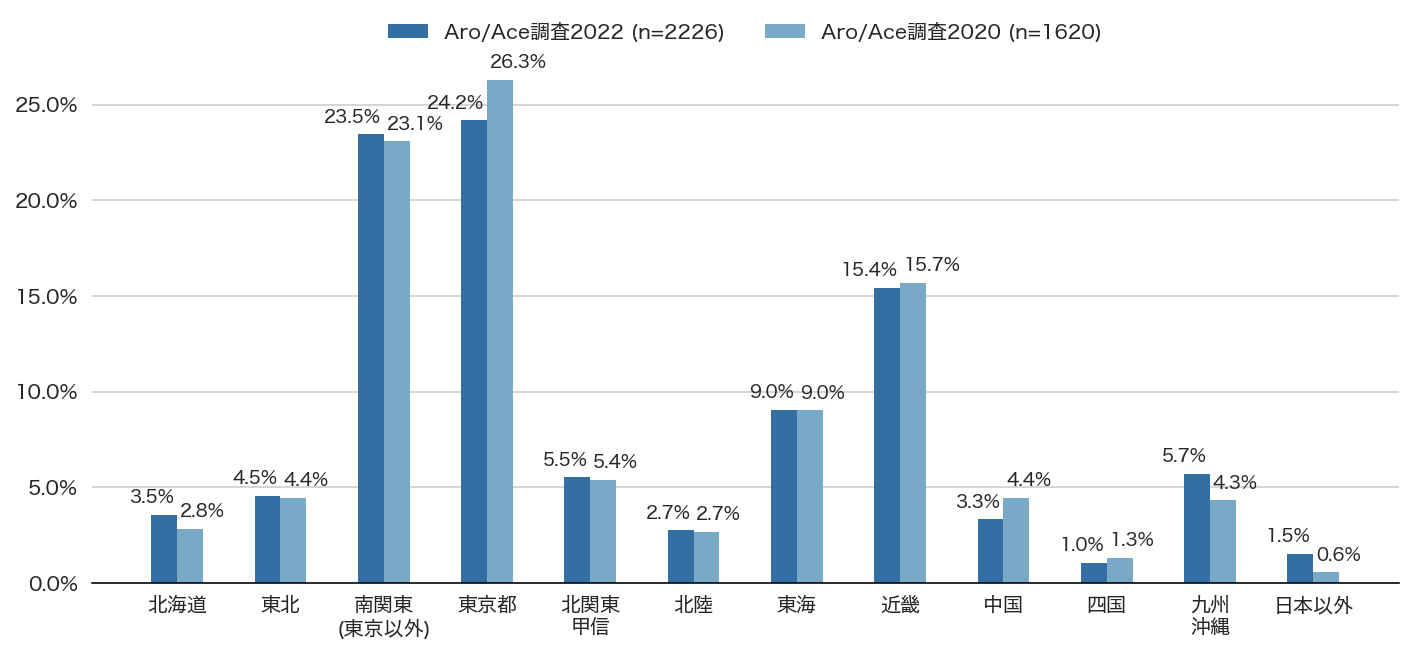

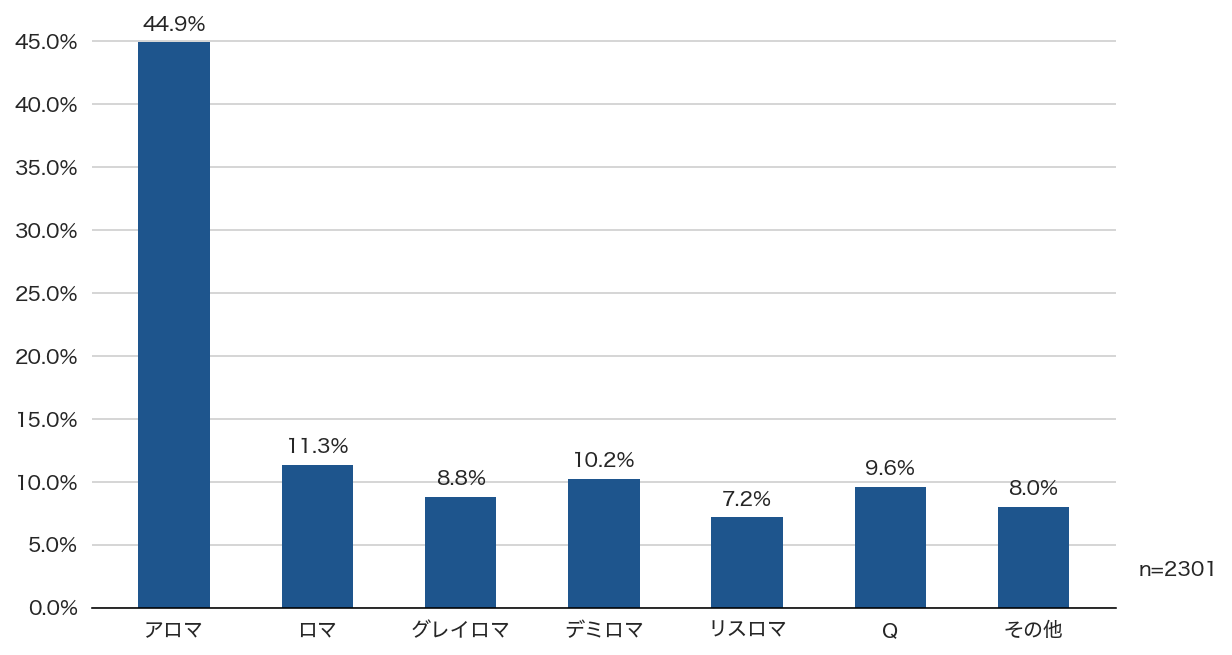

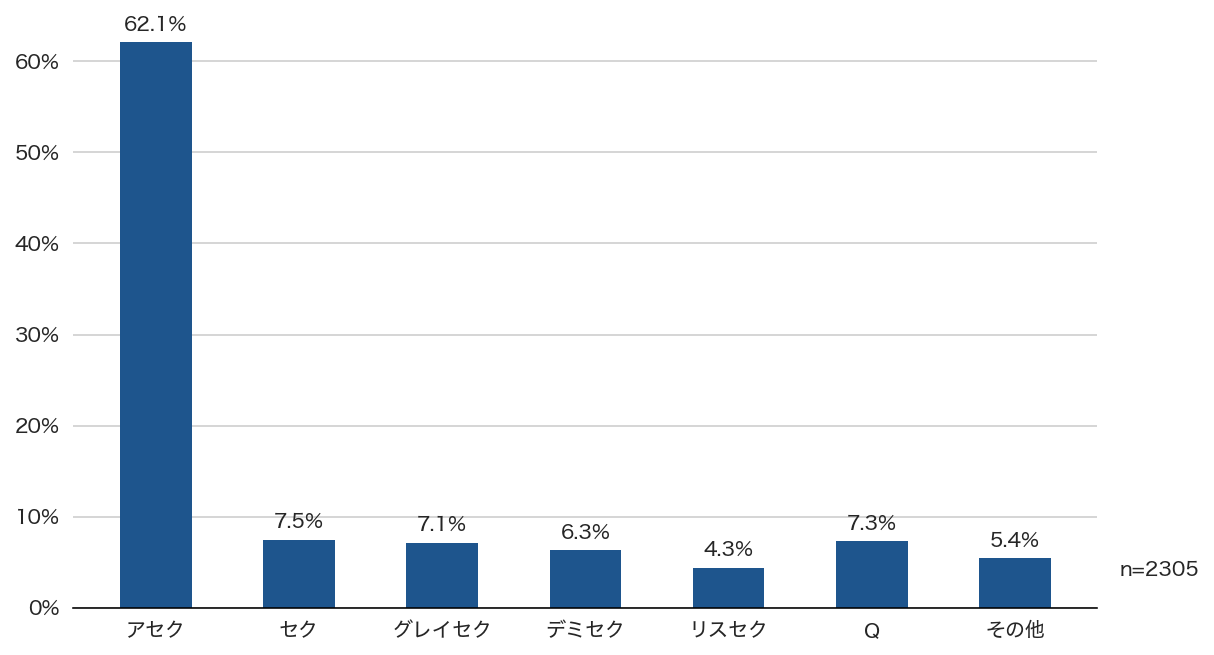

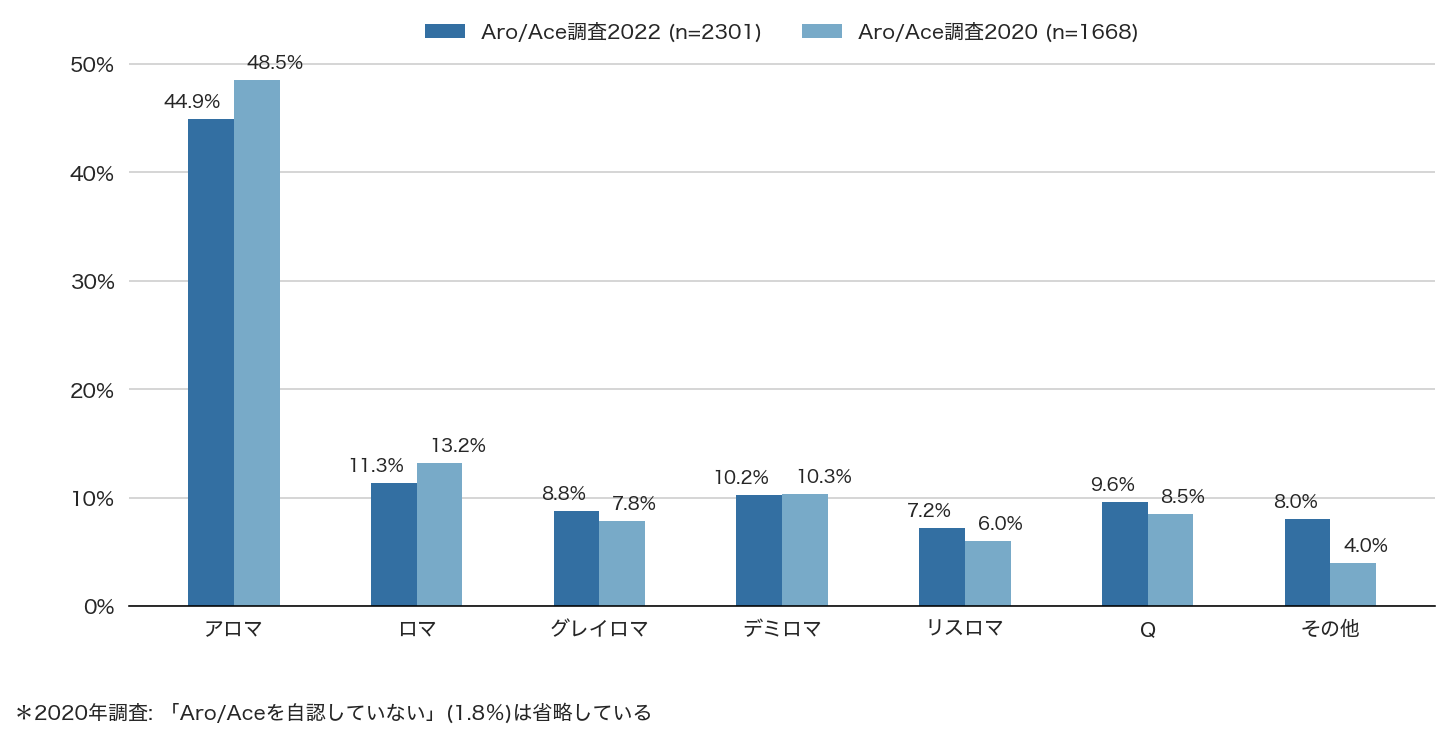

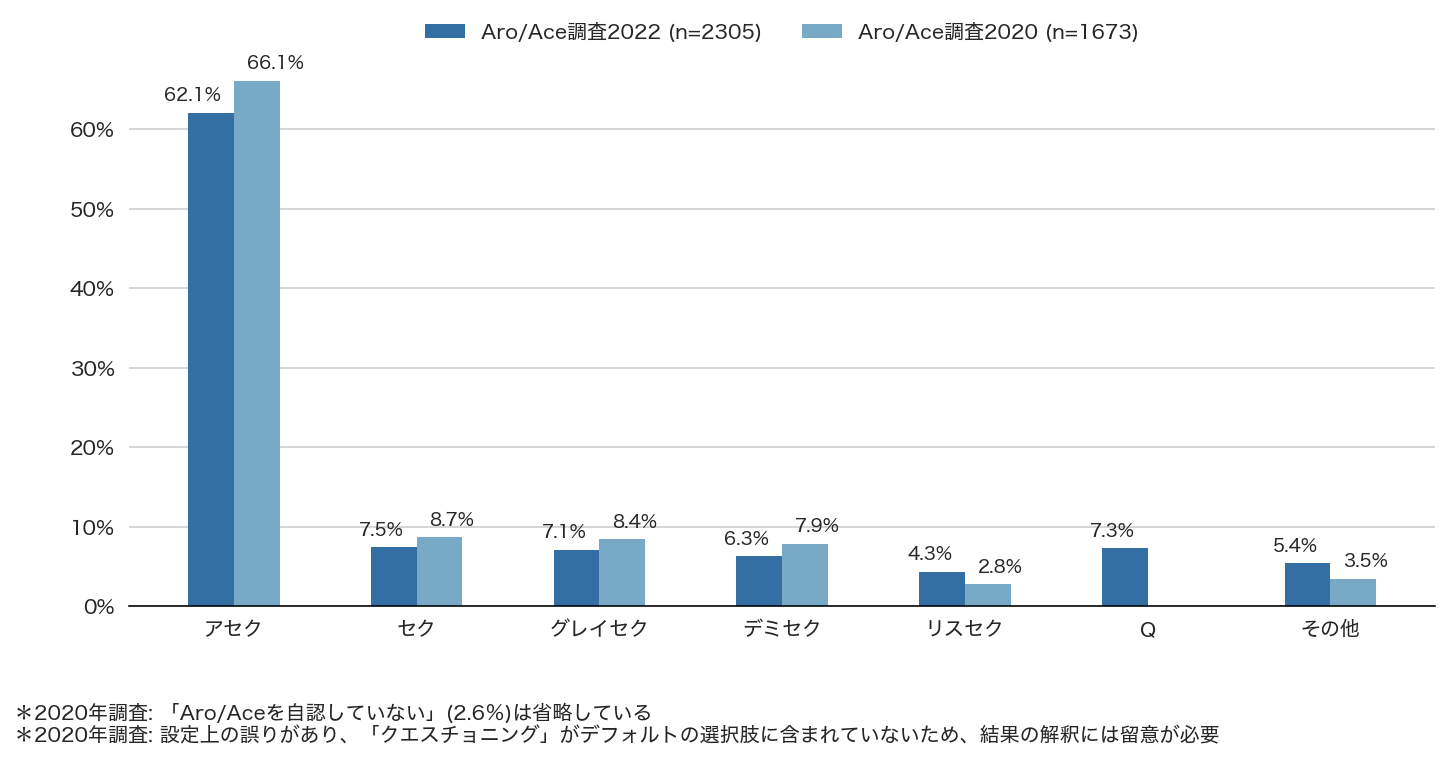

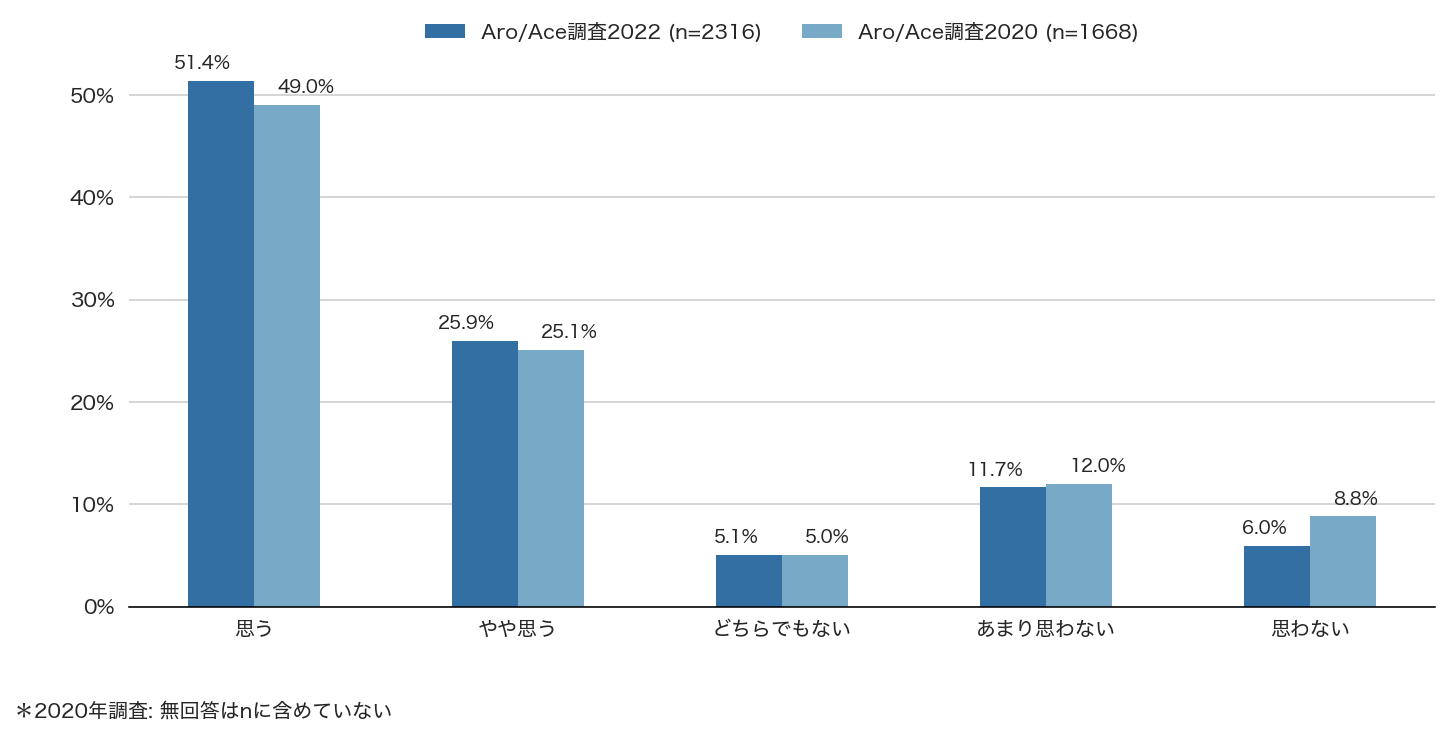

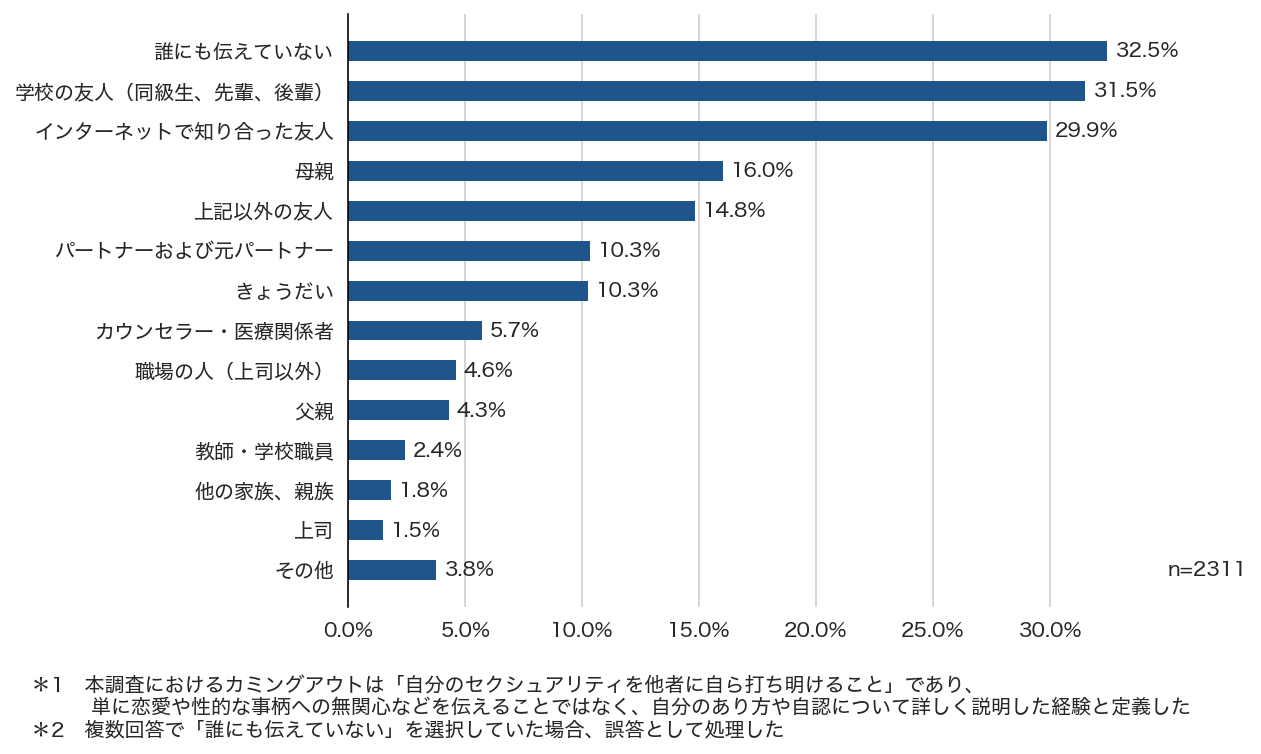

/var/folders/5g/gdhb1py554jdy7kh5f89k0mw0000gn/T/ipykernel_52361/2594794609.py:79: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, count in df[group_by].dropna().value_counts().iteritems():


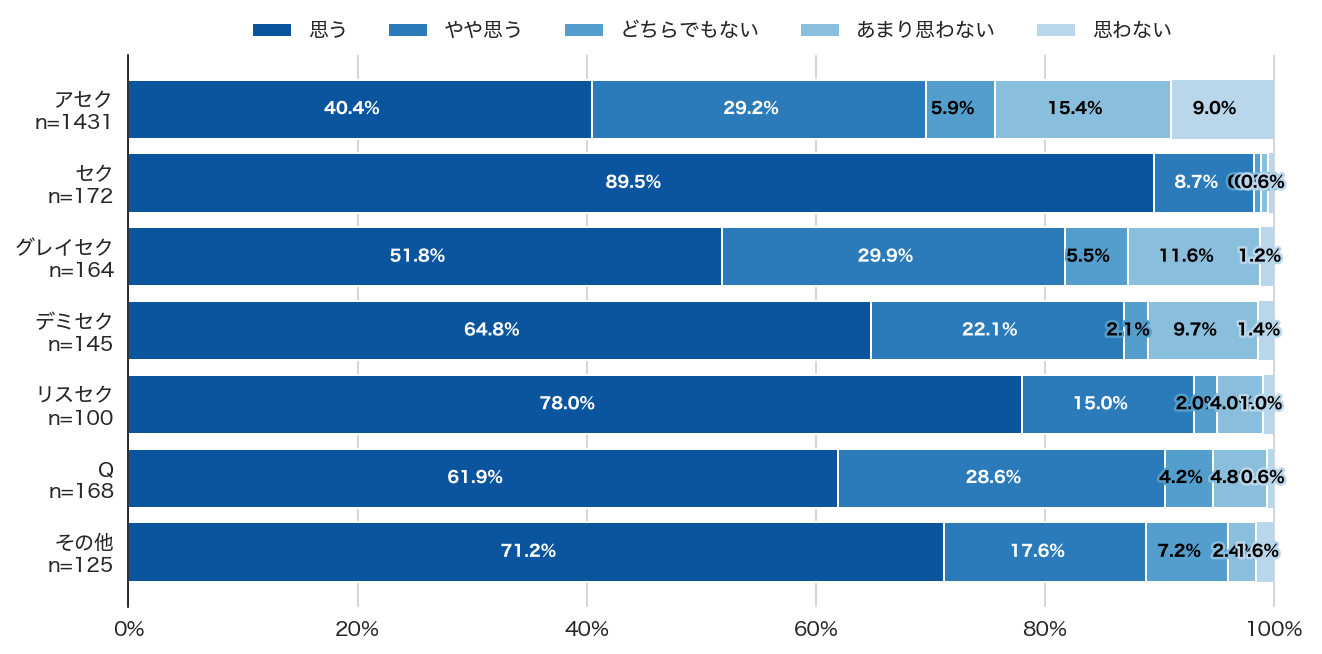

/var/folders/5g/gdhb1py554jdy7kh5f89k0mw0000gn/T/ipykernel_52361/2594794609.py:79: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, count in df[group_by].dropna().value_counts().iteritems():


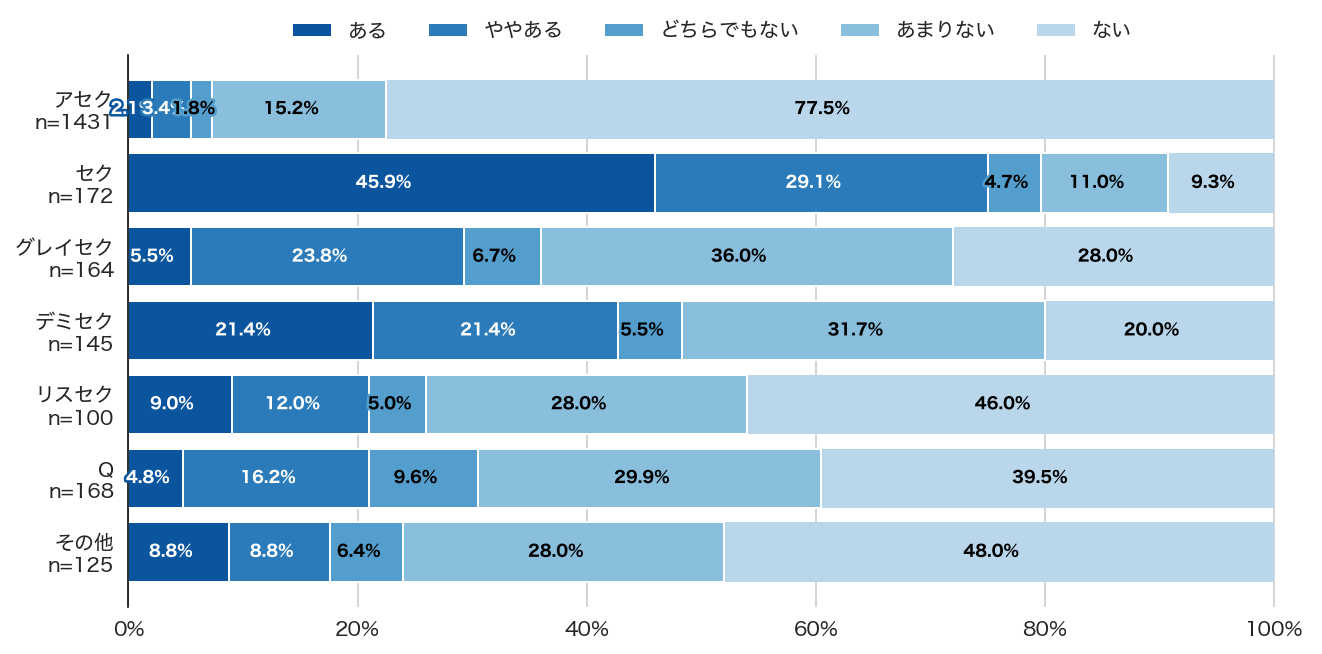

/var/folders/5g/gdhb1py554jdy7kh5f89k0mw0000gn/T/ipykernel_52361/2594794609.py:79: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, count in df[group_by].dropna().value_counts().iteritems():


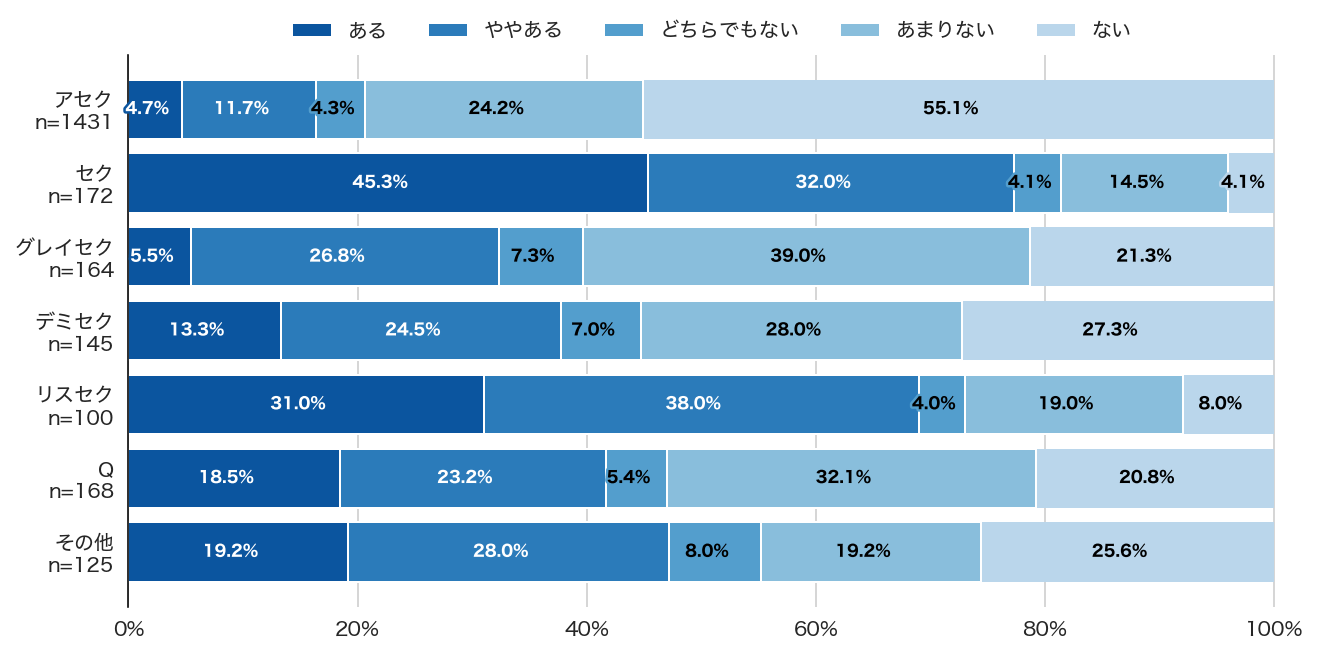

/var/folders/5g/gdhb1py554jdy7kh5f89k0mw0000gn/T/ipykernel_52361/2594794609.py:79: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, count in df[group_by].dropna().value_counts().iteritems():


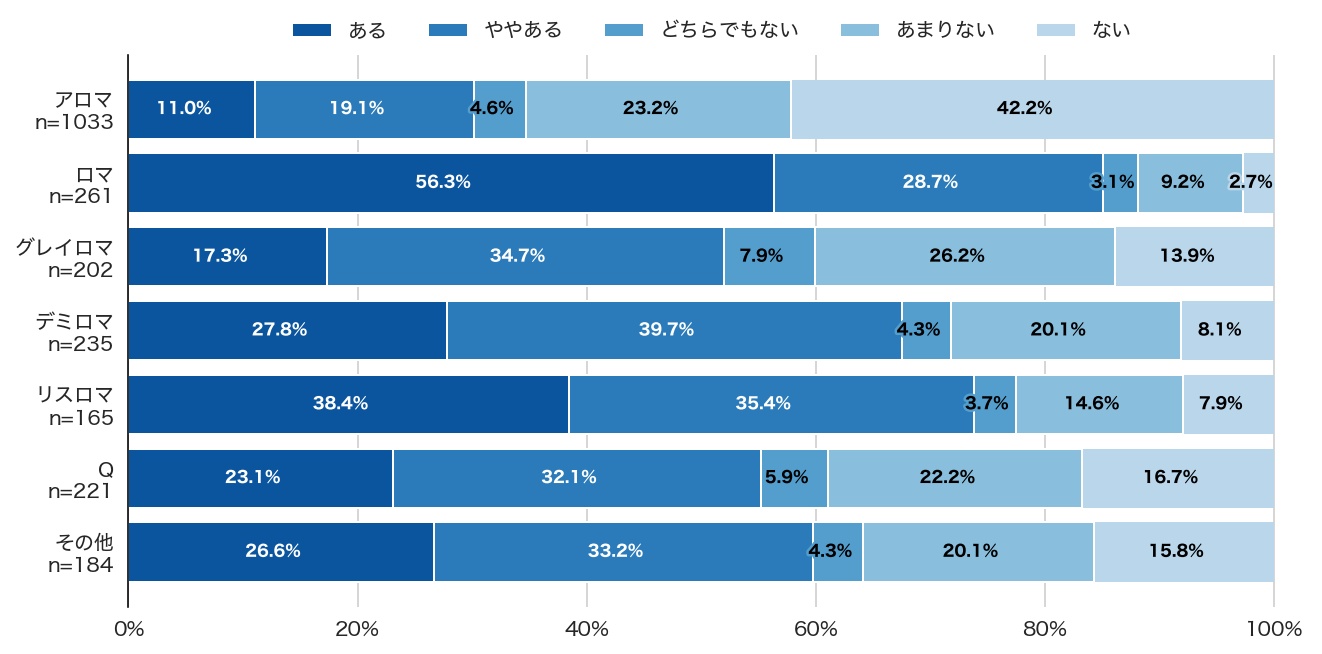

/var/folders/5g/gdhb1py554jdy7kh5f89k0mw0000gn/T/ipykernel_52361/2594794609.py:79: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, count in df[group_by].dropna().value_counts().iteritems():


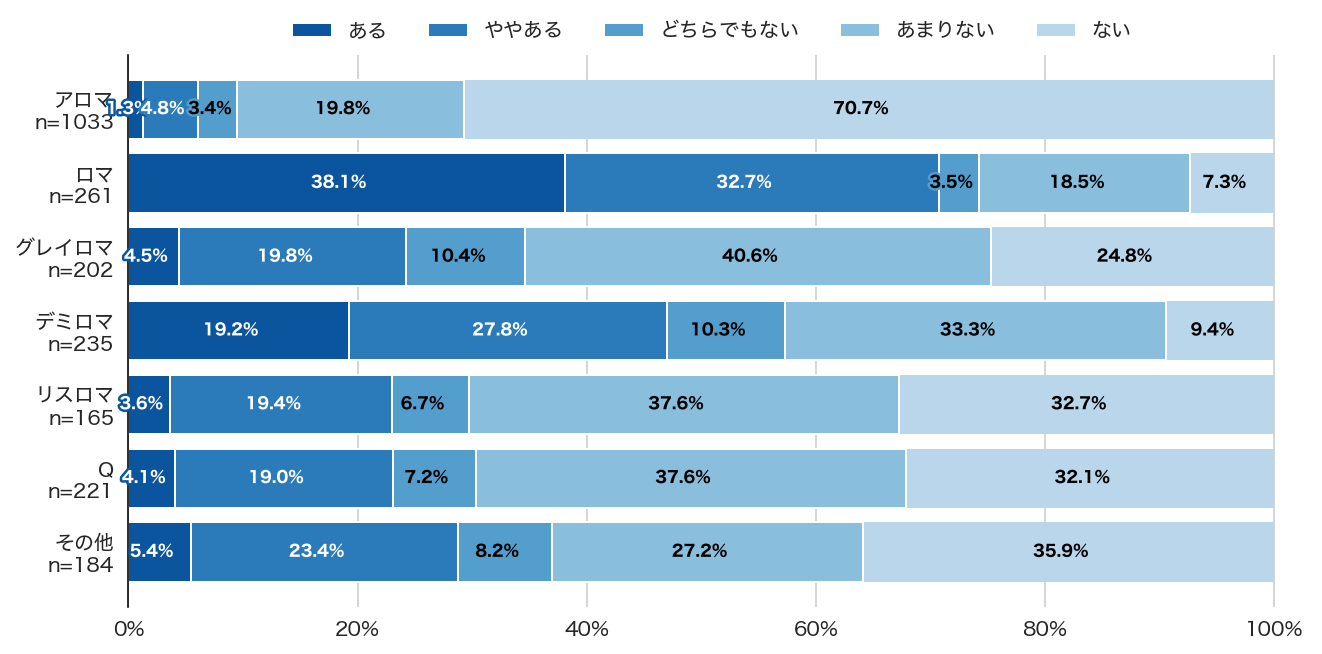

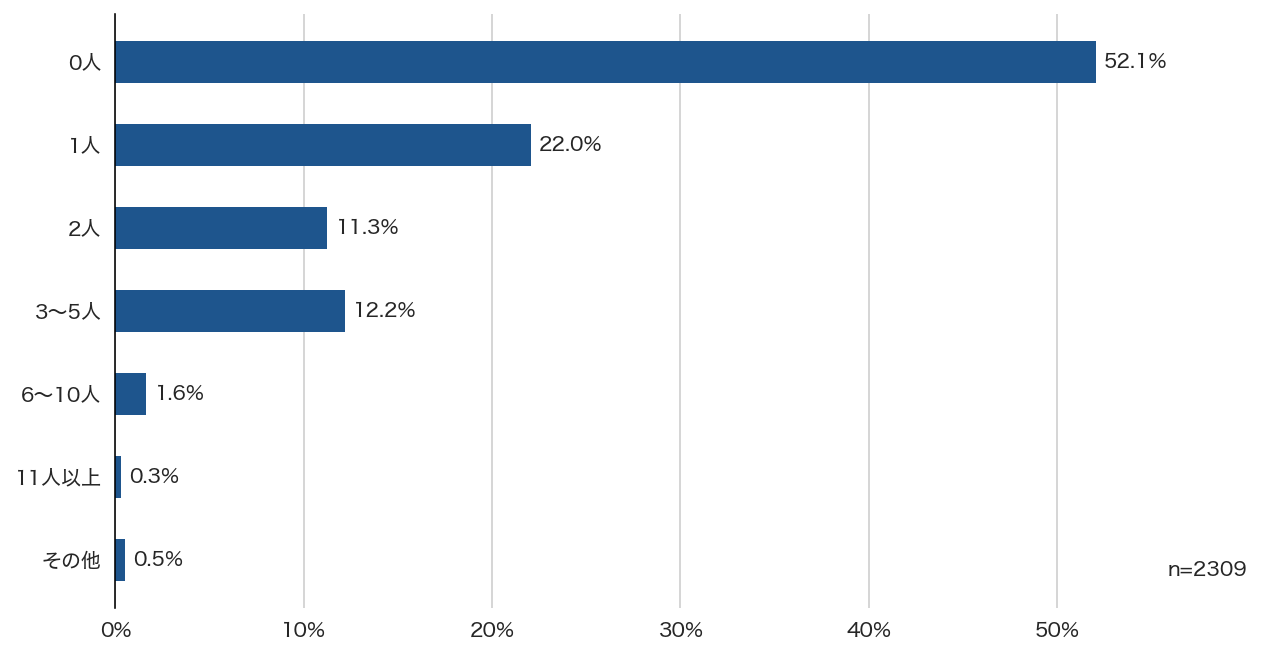

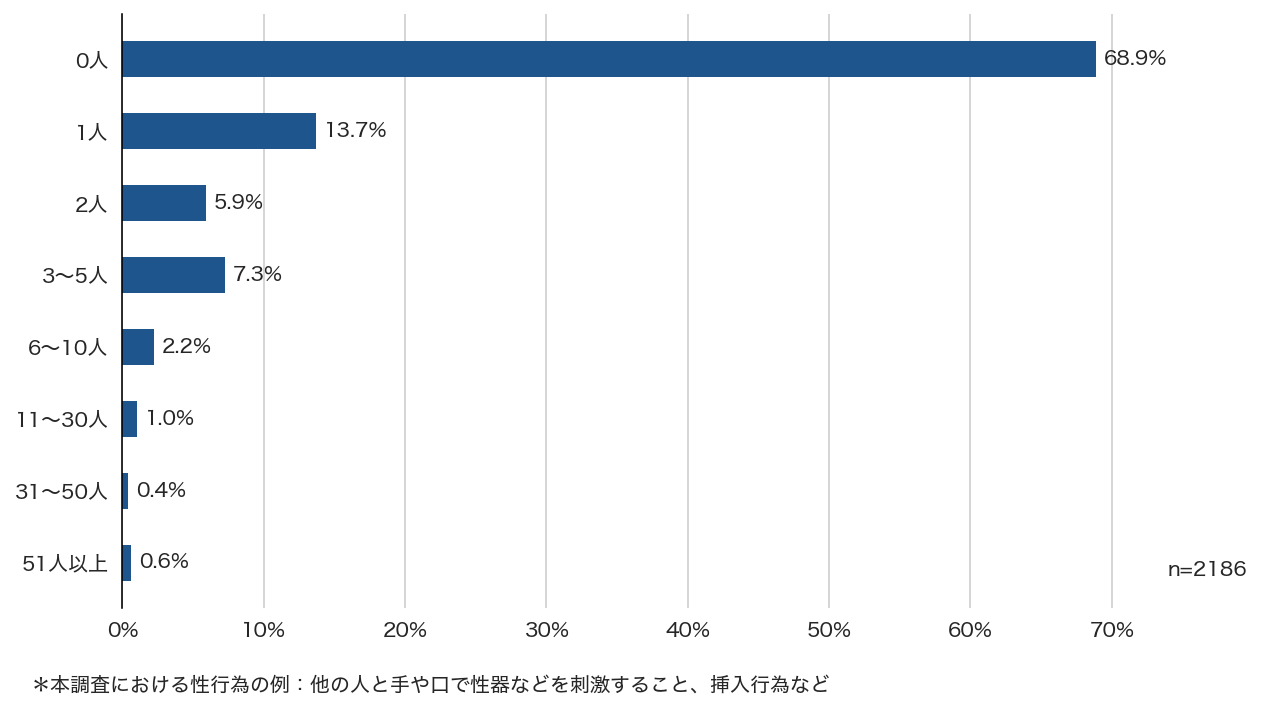

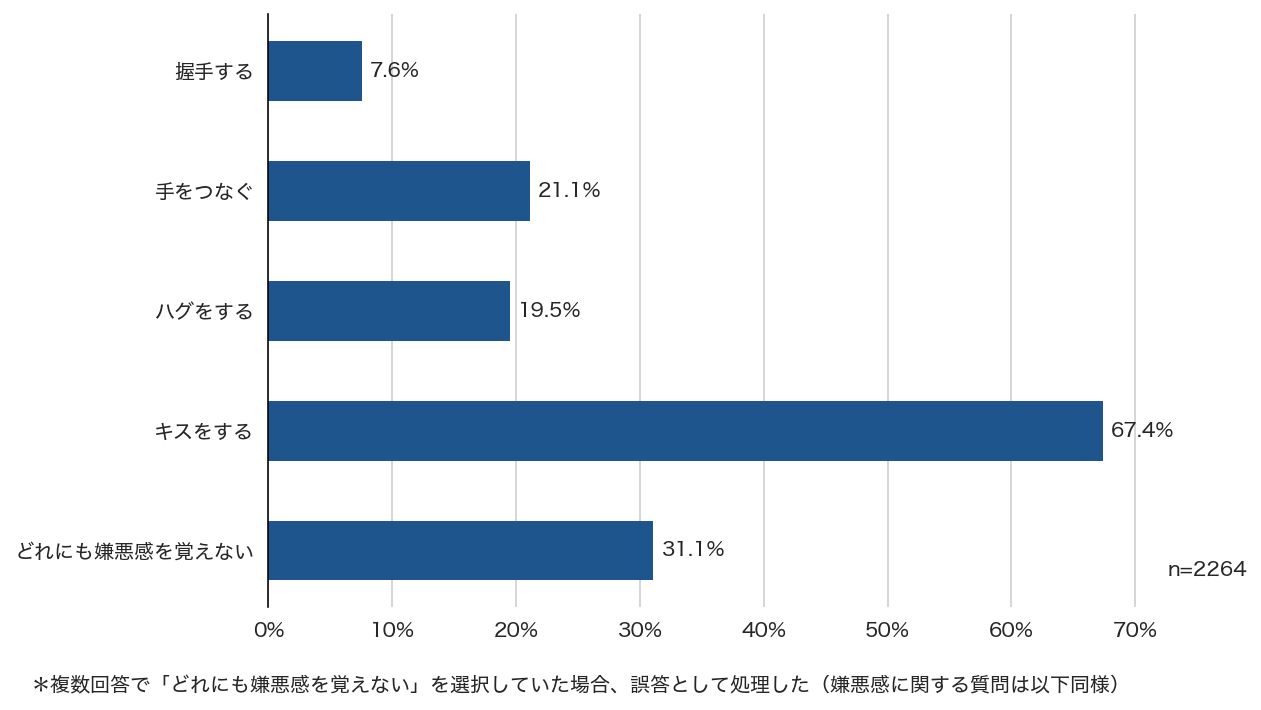

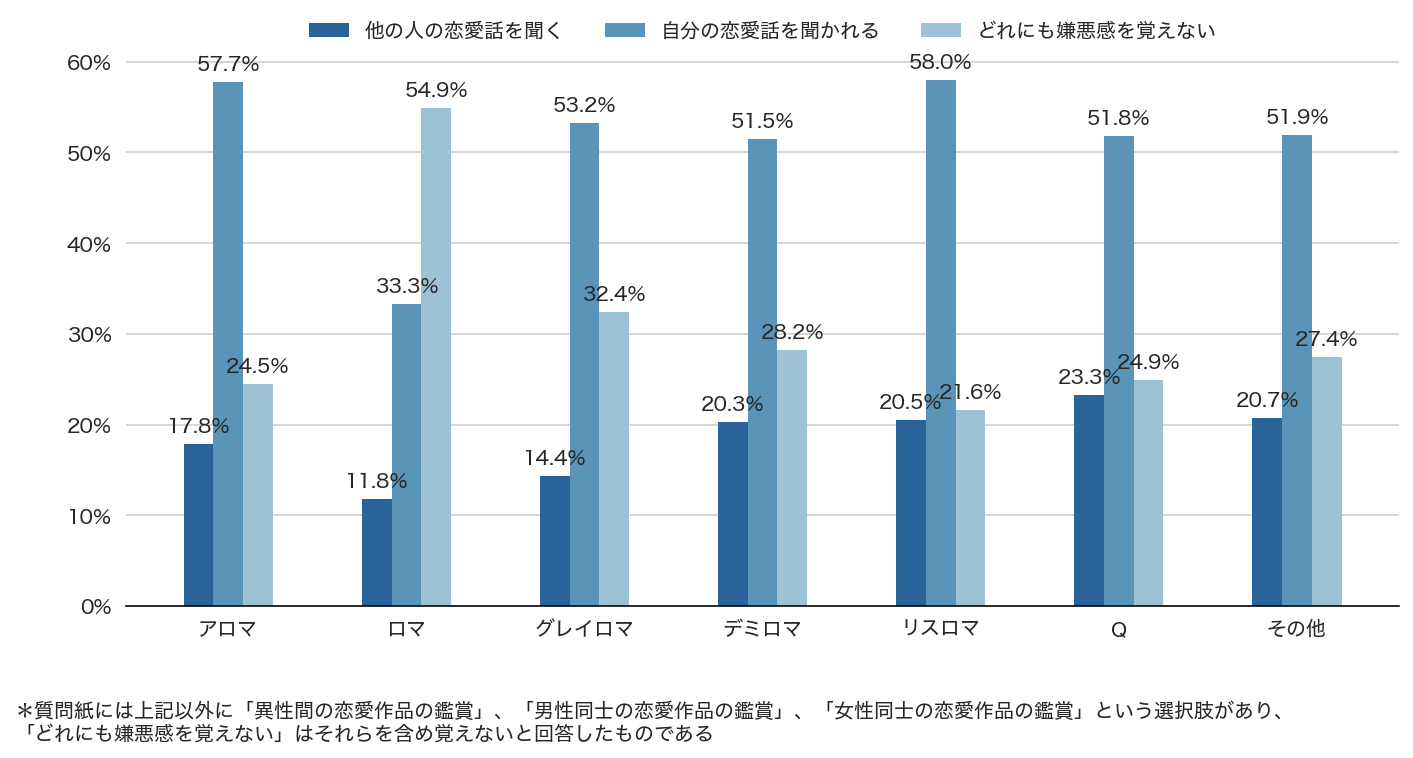

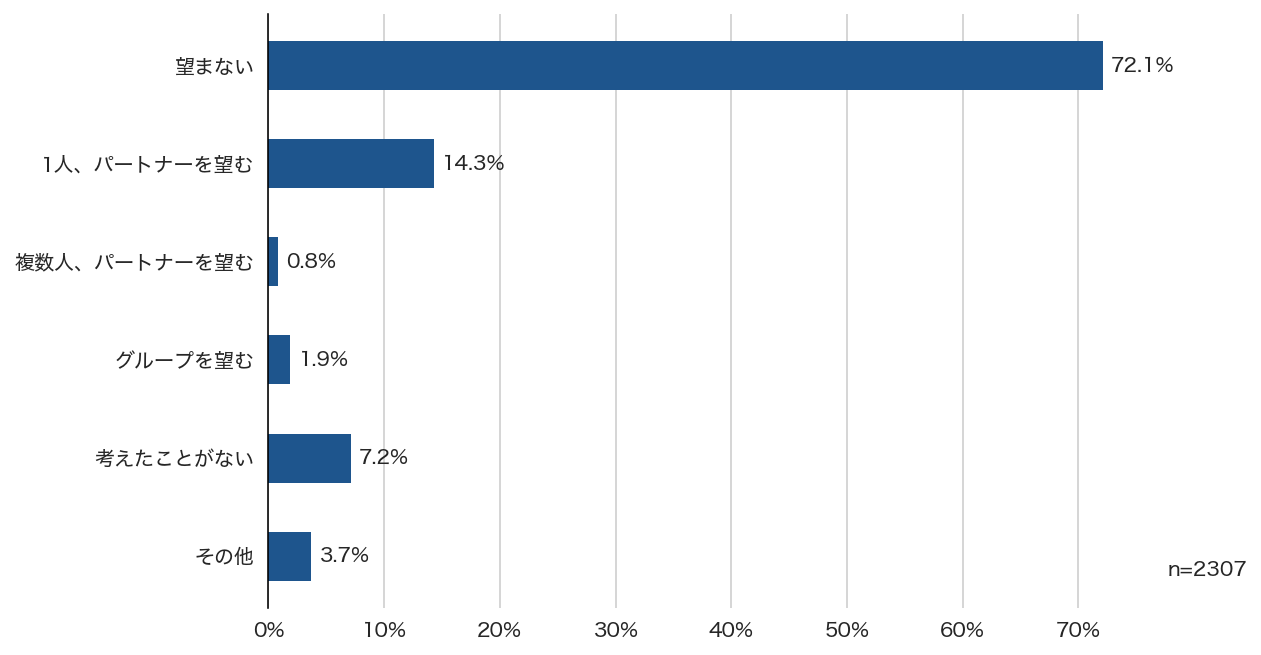

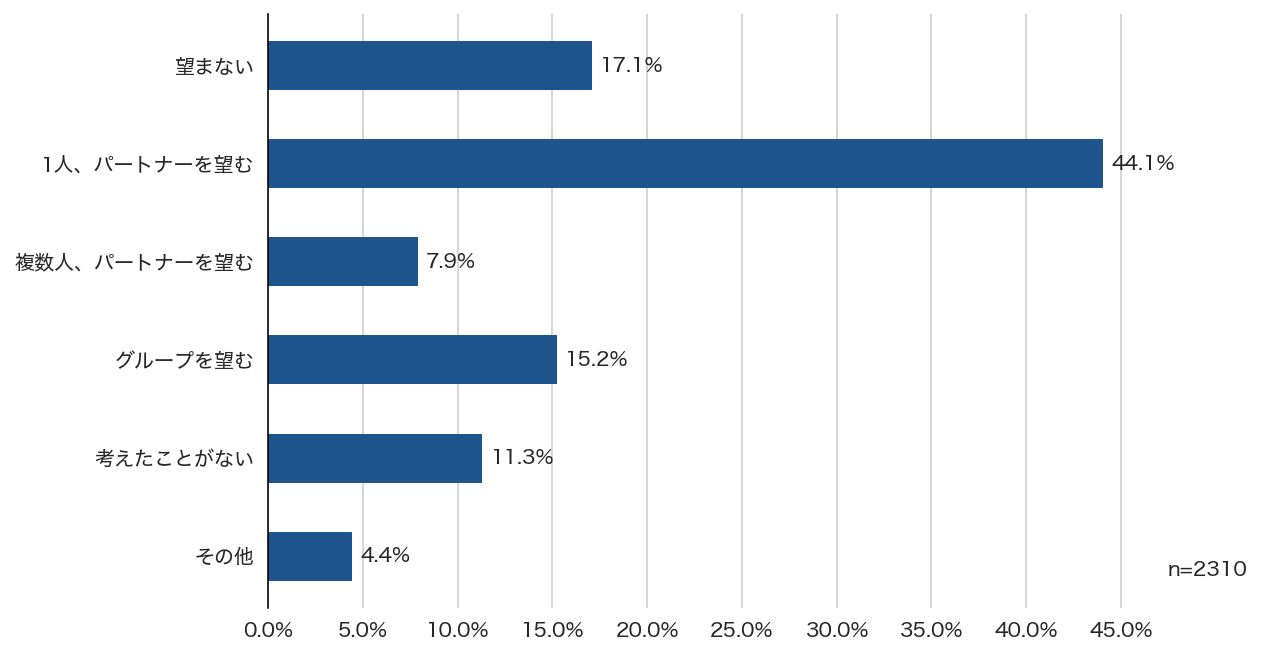

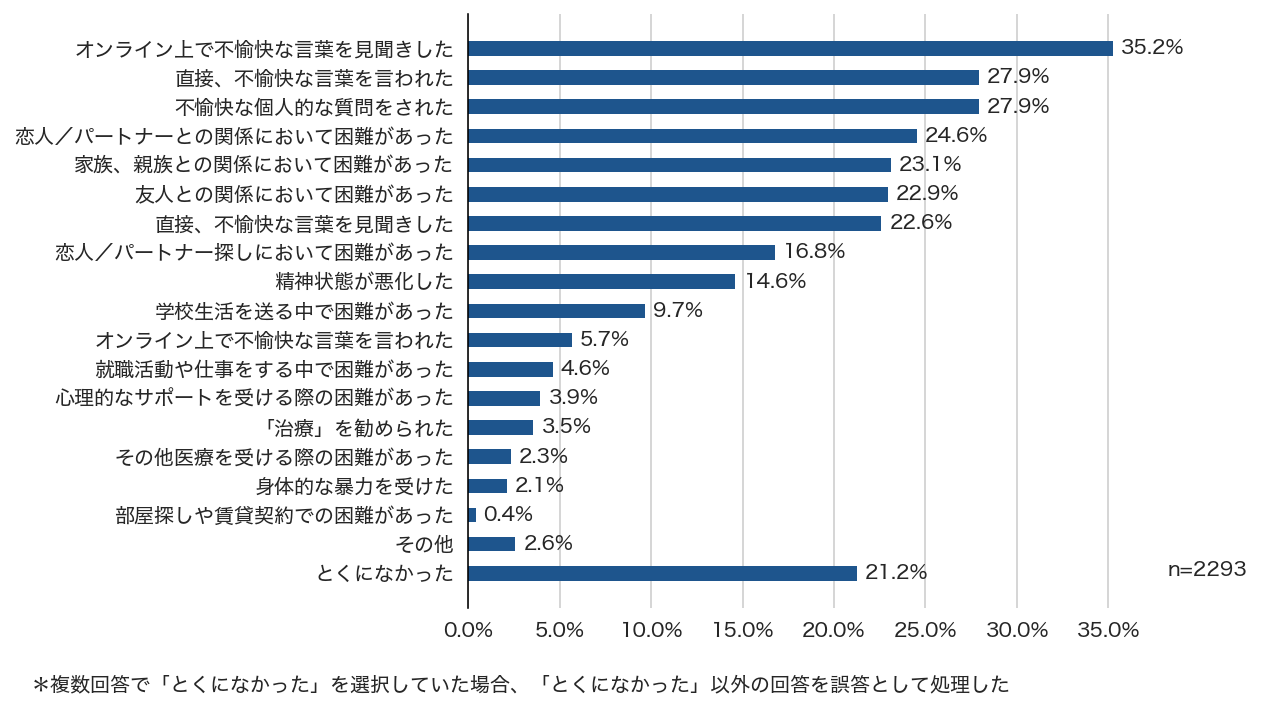

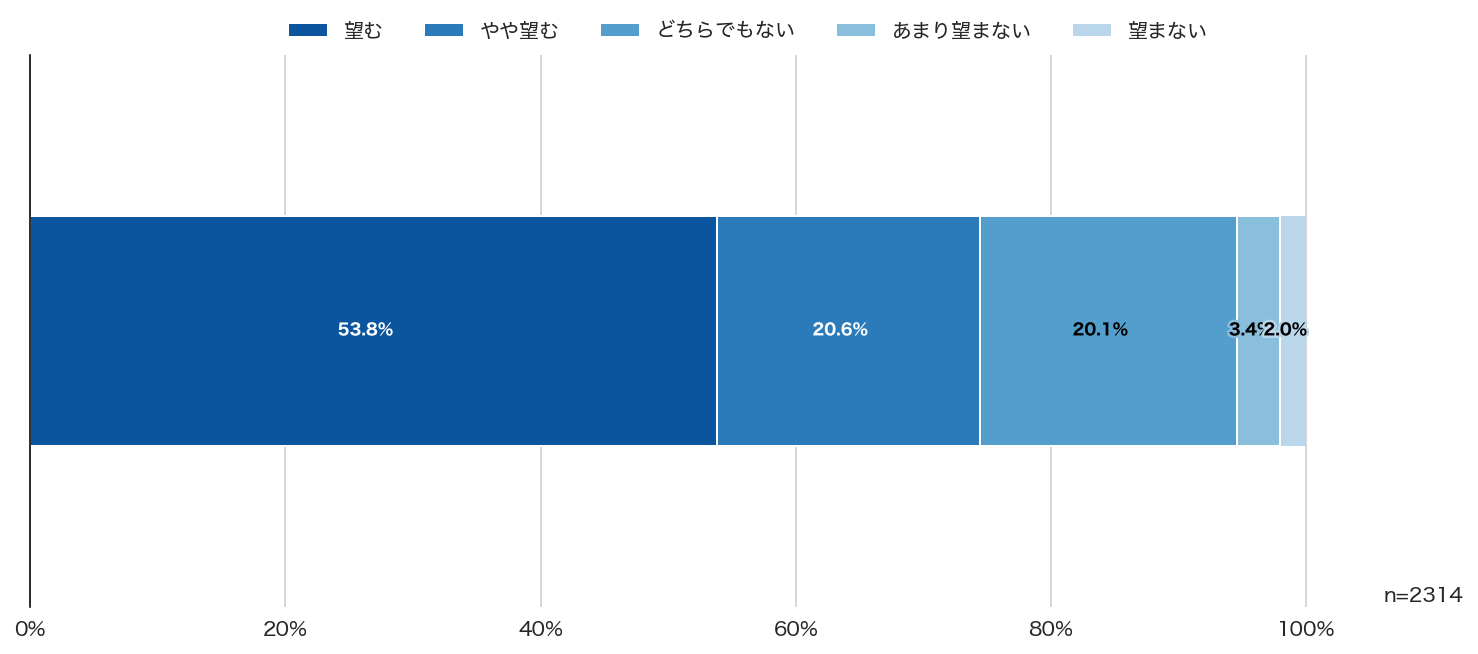

/var/folders/5g/gdhb1py554jdy7kh5f89k0mw0000gn/T/ipykernel_52361/2594794609.py:79: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, count in df[group_by].dropna().value_counts().iteritems():


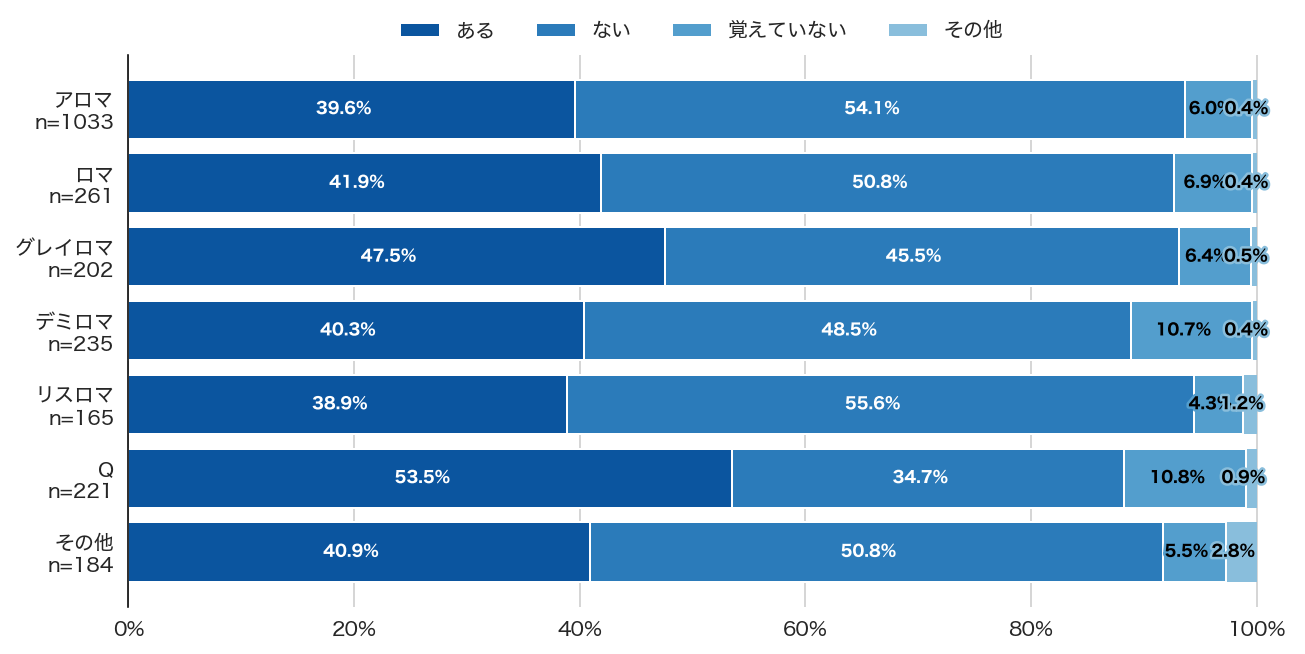

/var/folders/5g/gdhb1py554jdy7kh5f89k0mw0000gn/T/ipykernel_52361/2594794609.py:79: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, count in df[group_by].dropna().value_counts().iteritems():


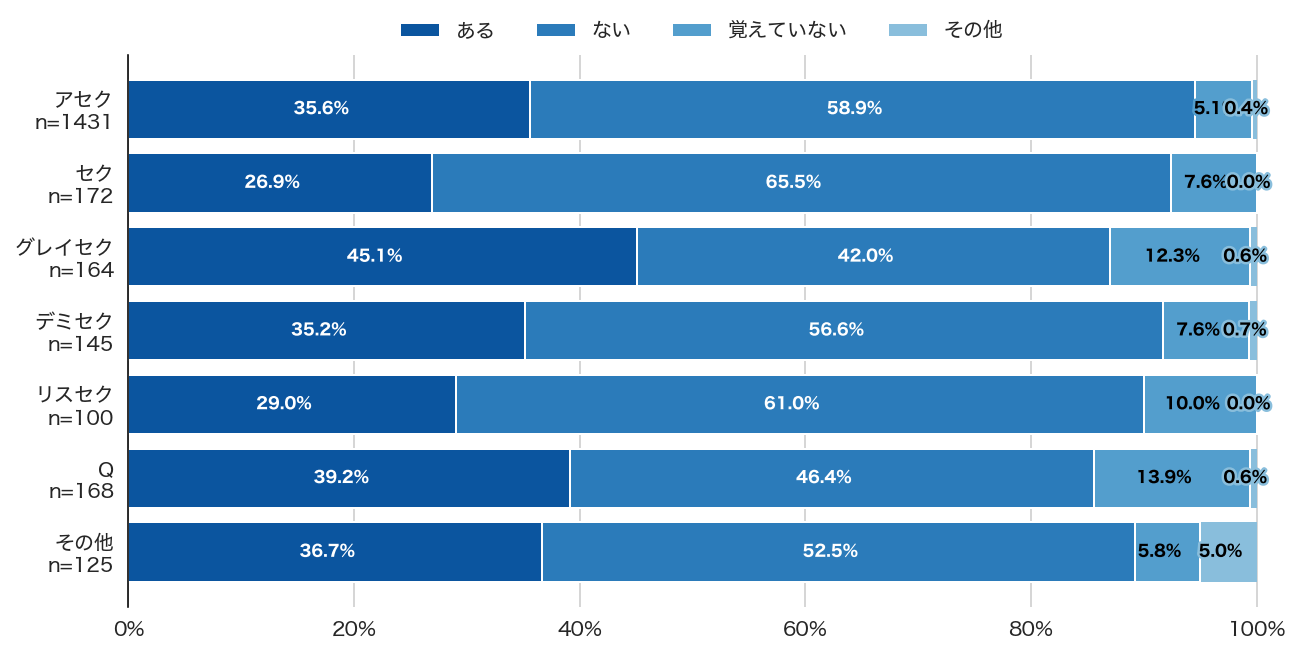

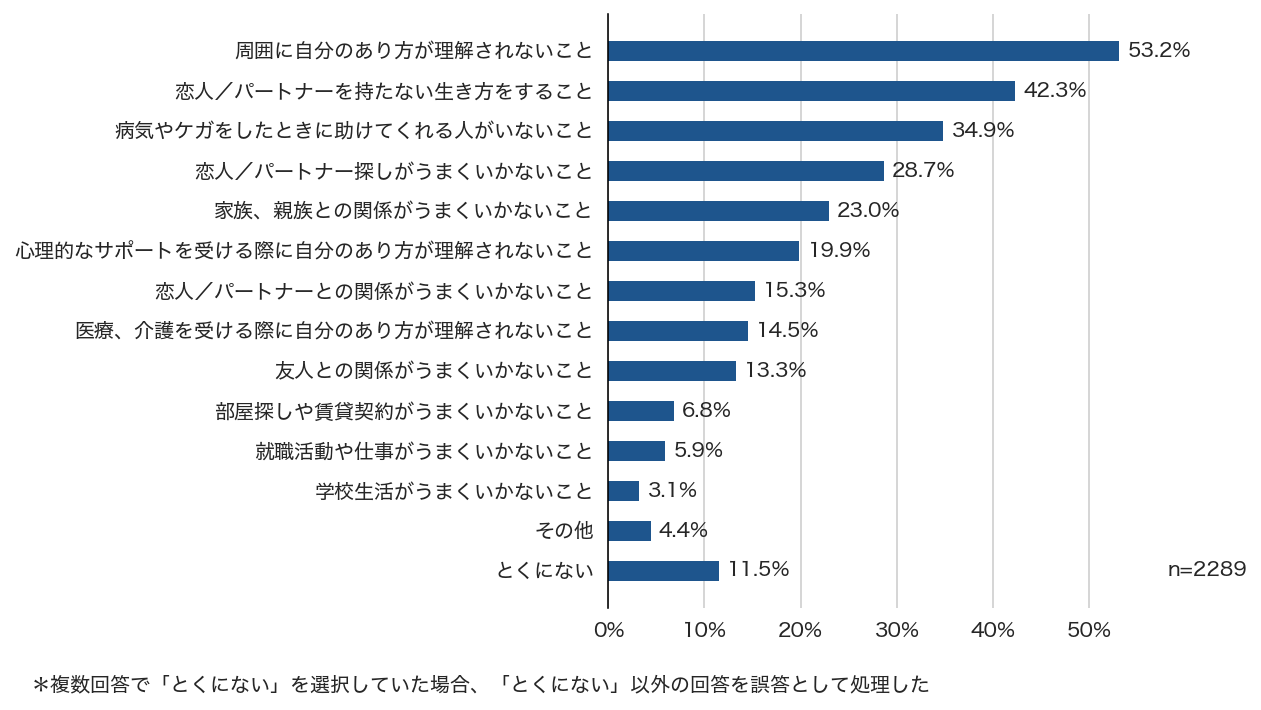

In [9]:
# 描画
reset_figure_num()

plot_stacked_hbar('M', '出生時の性別と、現在自分が捉えている性別が「一致」しているか')
plot_stacked_hbar_with_comparison('M', './data/cis_gender_2020.csv', '「一致」していると思うか', 'v', '出生時の性別と、現在自分が捉えている性別が「一致」しているか (前回調査との比較)')
render_sex_plot()
render_age_plot()
render_residence_plot()
plot_bar('Y', 'v', '自認している恋愛的指向のアイデンティティ')
plot_bar('AN', 'v', '自認している性的指向のアイデンティティ')
# 主な恋愛的指向×性的指向アイデンティティの組み合わせ	Y	AN	表	＊組み合わせの中から任意で抜粋しているため、回答数による降順ではない	IDの組み合わせ、前年度と比較→縦軸にセクシュアリティの組み合わせ、横軸に2020・2022を入れて1枚の大きな表にしてほしいです（右の青い部分を見て）

plot_bar_with_comparison('Y', './data/romantic_orientations_2020.csv', '恋愛指向', 'v', '自認している恋愛指向のアイデンティティ (前回調査との比較)', '＊2020年調査: 「Aro/Aceを自認していない」(1.8％)は省略している')
plot_bar_with_comparison('AN', './data/sexual_orientations_2020.csv', '性的指向', 'v', '自認している性的指向のアイデンティティ (前回調査との比較)', '＊2020年調査: 「Aro/Aceを自認していない」(2.6％)は省略している\n＊2020年調査: 設定上の誤りがあり、「クエスチョニング」がデフォルトの選択肢に含まれていないため、結果の解釈には留意が必要')
plot_bar_with_comparison('AF', './data/libido_2020.csv', '性欲の有無', 'v', '自分に「性欲」があると思うか (前回調査との比較)', '＊2020年調査: 無回答はnに含めていない')

plot_bar('AZ', 'h', '自分がAro/Aceであることをカミングアウトした相手(複数回答)',
    '＊1　本調査におけるカミングアウトは「自分のセクシュアリティを他者に自ら打ち明けること」であり、\n　　　単に恋愛や性的な事柄への無関心などを伝えることではなく、自分のあり方や自認について詳しく説明した経験と定義した\n＊2　複数回答で「誰にも伝えていない」を選択していた場合、誤答として処理した',
    other_groups=['その他'],
    sort=True)

plot_stacked_hbar_grouped('AF', 'AN', '自分に"性欲"があると思うか×性的指向')
plot_stacked_hbar_grouped('AE', 'AN', '他の人と性行為をしようと思うことがあるか×性的指向')
plot_stacked_hbar_grouped('AH', 'AN', '他の人を性的な意味で魅力的だと感じたことがあるか×性的指向')

plot_stacked_hbar_grouped('S', 'Y', '胸が「ドキドキ」する感情を抱くことがあるか×恋愛的指向')
plot_stacked_hbar_grouped('Q', 'Y', '「付き合いたい」と思うことがあるか×恋愛的指向')

plot_bar('BB', 'h', '過去の恋人人数')
plot_bar('CX', 'h', 'これまでに性行為をした人数', '＊本調査における性⾏為の例：他の⼈と⼿や⼝で性器などを刺激すること、挿⼊⾏為など')

plot_bar('CH', 'h', '特定の行動に対する嫌悪感(複数回答)', '＊複数回答で「どれにも嫌悪感を覚えない」を選択していた場合、誤答として処理した（嫌悪感に関する質問は以下同様）', ['どれにも嫌悪感を覚えない'])

plot_bar_grouped('CE', 'Y', 'v', '恋愛要素のあることに対する嫌悪感×恋愛的指向', '＊質問紙には上記以外に「異性間の恋愛作品の鑑賞」、「男性同士の恋愛作品の鑑賞」、「女性同士の恋愛作品の鑑賞」という選択肢があり、\n「どれにも嫌悪感を覚えない」はそれらを含め覚えないと回答したものである', filter_answers=['他の人の恋愛話を聞く', '自分の恋愛話を聞かれる', 'どれにも嫌悪感を覚えない'], palette=palette_4)
plot_bar('BK', 'h', '恋愛関係かつ性的関係のあるパートナー等を望むか')
plot_bar('BM', 'h', '恋愛関係も性的関係もないパートナー等を望むか')
plot_bar('CO', 'h', 'Aro/Aceであることで経験したこと（複数回答）', '＊複数回答で「とくになかった」を選択していた場合、「とくになかった」以外の回答を誤答として処理した', other_groups=['その他', 'とくになかった'], sort=True)

plot_stacked_hbar('CC', 'Aro/Aceに関する作品を望むか')

plot_stacked_hbar_grouped('AB', 'Y', '自認（性的指向）をためらったことがあるか×性的指向')
plot_stacked_hbar_grouped('AP', 'AN', '自認（恋愛的指向）をためらったことがあるか×恋愛的指向')

plot_bar('CQ', 'h', 'Aro/Aceとして生きる中で不安を感じること（複数回答）', '＊複数回答で「とくにない」を選択していた場合、「とくにない」以外の回答を誤答として処理した', other_groups=['その他', 'とくにない'], sort=True)


In [10]:
#　単純集計をすべてグラフに起こす

%matplotlib agg

import os

os.makedirs('out/images-単純集計', 0o755, exist_ok=True)

# for column in df:
for column in df:
    if column == 'A':
        # Skip timestamp column
        continue

    values = df[column].dropna()
    if choices_df.loc[column, '複数回答'] == 1:
        values = values[df[column].astype(bool)]  # drop empty list
    n = len(values)

    grouped = values.explode().value_counts() * 100 / n
    if len(grouped) > 50:
        print(f"column {column} has too many variations ({len(grouped)})")
        continue
    if len(grouped) == 0:
        print(f"column {column} is empty")
        continue

    if grouped.index.dtype.kind in ['i', 'u', 'f', 'c', 'm']:
        grouped.sort_index(inplace=True)
    else:
        choice_list = choices_df.loc[column, '選択肢']
        if choice_list:
            choice_series = pd.Series(choice_list)
            if not choice_series.str.isnumeric().all():
                grouped = grouped.reindex(pd.concat([choice_series, grouped.index.to_series()]).unique(), fill_value=0)
    title = questions.loc[column]
    figure = hbar(grouped, n, title)
    figure.suptitle(title)
    figure.savefig(f"out/images-単純集計/figure-{column.rjust(2, '_')}-{questions[column].replace('/', '_')}.png", format="png", dpi=144)

%matplotlib inline


/Users/ypresto/repo/github.com-private/ypresto/asloop-survey/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


column AC has too many variations (660)
column AQ has too many variations (466)
column AW has too many variations (497)
column CD has too many variations (620)
column CP has too many variations (588)
column CR has too many variations (324)
column CT has too many variations (530)
column DJ has too many variations (307)
column DK is empty
column DL is empty


In [11]:
def render_cq_map():
    from japanmap import picture

    table = df[['E', 'CQ']].explode('CQ')

    computed = pd.crosstab(table['E'], table['CQ']).divide(df['E'].value_counts(), axis='index')

    for col in computed:
        series = computed[col]

        cmap = plt.get_cmap('Reds')

        norm = plt.Normalize(vmin=series.min(), vmax=series.max())
        def fcol(x): return '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
        figure = plt.figure(dpi=144)
        plt.colorbar(plt.cm.ScalarMappable(norm, cmap))
        plt.imshow(picture(series.apply(fcol)))
        figure.axes[0].xaxis.grid(False)
        figure.axes[0].yaxis.grid(False)
        plt.title(col)
        plt.show()

# render_cq_map()
